# Loading data

In [111]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv("/content/drive/MyDrive/sadhana/counter_service.csv")
data.head()

call_id  queue_id  service_id  counter_id  user_id called_date  \
0       28        45           1           2        2  2024-01-25   
1       29        46           1           2        2  2024-01-25   
2       30        48           2           2        2  2024-01-25   
3       31        47           1           2        2  2024-01-25   
4       32        50           3           3        2  2024-01-25   

            started_at             ended_at waiting_time served_time  \
0  2024-01-25 18:26:13  2024-01-25 18:34:14     00:06:45    00:08:01   
1  2024-01-25 18:34:16  2024-01-25 18:34:24     00:13:39    00:00:08   
2  2024-01-25 18:34:53                  NaN     00:00:13         NaN   
3  2024-01-25 18:35:14  2024-01-25 18:35:18     00:10:17    00:00:04   
4  2024-01-25 18:35:58  2024-01-25 18:37:00     00:00:29    00:01:02   

  turn_around_time           service_name counter_name      agent_name  \
0         00:14:46                WIS (W)    Counter 2  Nandu Acharaya   
1         00:13:47                WIS (W)    Counter 2  Nandu Acharaya   
2              NaN  NEW REGISTRATION (NR)    Counter 2  Nandu Acharaya   
3         00:10:21                WIS (W)    Counter 2  Nandu Acharaya   
4         00:01:31           TRAINING (T)    Counter 3  Nandu Acharaya   

  call_status  
0      served  
1      served  
2         NaN  
3      served  
4      served

# Data Preprocessing



In [113]:
data['called_date'] = pd.to_datetime(data['called_date'])
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])


In [114]:
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

data['waiting_time_seconds'] = data['waiting_time'].apply(time_to_seconds)
data['served_time_seconds'] = data['served_time'].apply(time_to_seconds)
data['turn_around_time_seconds'] = data['turn_around_time'].apply(time_to_seconds)


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   call_id                   3354 non-null   int64         
 1   queue_id                  3354 non-null   int64         
 2   service_id                3354 non-null   int64         
 3   counter_id                3354 non-null   int64         
 4   user_id                   3354 non-null   int64         
 5   called_date               3354 non-null   datetime64[ns]
 6   started_at                3354 non-null   datetime64[ns]
 7   ended_at                  3335 non-null   datetime64[ns]
 8   waiting_time              3354 non-null   object        
 9   served_time               2737 non-null   object        
 10  turn_around_time          2737 non-null   object        
 11  service_name              3354 non-null   object        
 12  counter_name        

# removing null values

In [116]:
data.isna().sum()

call_id                       0
queue_id                      0
service_id                    0
counter_id                    0
user_id                       0
called_date                   0
started_at                    0
ended_at                     19
waiting_time                  0
served_time                 617
turn_around_time            617
service_name                  0
counter_name                  0
agent_name                    0
call_status                  19
waiting_time_seconds          0
served_time_seconds         617
turn_around_time_seconds    617
dtype: int64

following columns have null values:
- ended_at             19
- served_time         617
- turn_around_time    617
- call status          19



In [117]:
average_served_time = data['served_time_seconds'].mean()
average_turn_around_time = data['turn_around_time_seconds'].mean()
data['ended_at'] = data.apply(
    lambda row: row['ended_at'] if pd.notnull(row['ended_at']) else row['started_at'] + pd.Timedelta(seconds=round(average_served_time)),
    axis=1
)

data['served_time_seconds'] = data['served_time_seconds'].fillna(average_served_time)

data['turn_around_time_seconds'] = data['turn_around_time_seconds'].fillna(average_turn_around_time)

data['call_status'] = data['call_status'].fillna('unknown')



In [118]:
services = data["service_name"].unique()
services_mapping = {i: service for i, service in enumerate(services)}
services_mapping

{0: 'WIS (W)', 1: 'NEW REGISTRATION (NR)', 2: 'TRAINING (T)'}

In [119]:
data["agent_name"].unique()

array(['Nandu Acharaya', 'Prem Jaishi', 'Suyog Tamang', 'Chhiring Ghale',
       'Mahima Kalikote', 'Sonam Tamang', 'Sagar Magar', 'Jyoti BK',
       'Lokendra Sunar', 'Bishnu Pd Marasini', 'Ajaya Limbu',
       'Rujan Shrestha', 'Rahul khadka'], dtype=object)

In [120]:
status_mapping = {'served': 1, 'unknown': 2, 'noshow': 3}
data['call_status_numeric'] = data['call_status'].map(status_mapping)

# removing outliers from continuous data columns ['waiting_time_seconds', 'served_time_seconds', 'turn_around_time_seconds']

In [121]:
for column in ['waiting_time_seconds', 'served_time_seconds', 'turn_around_time_seconds']:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# descriptive stat

In [122]:
descriptive_stats = data[['waiting_time_seconds', 'served_time_seconds', 'turn_around_time_seconds']].describe()
mean_values = descriptive_stats.loc['mean']
median_values = descriptive_stats.loc['50%']
std_values = descriptive_stats.loc['std']

print("Descriptive Statistics:")
print(descriptive_stats)
print("\nMean Values:")
print(mean_values)
print("\nMedian Values:")
print(median_values)
print("\nStandard Deviation Values:")
print(std_values)


Descriptive Statistics:
       waiting_time_seconds  served_time_seconds  turn_around_time_seconds
count           3036.000000          3036.000000               3036.000000
mean            3891.881423           621.896529               4467.004533
std             2579.068876           310.403761               2305.367558
min                0.000000             1.000000                 91.000000
25%             1707.750000           383.000000               2626.000000
50%             3562.500000           721.000000               4872.068688
75%             5661.000000           772.000000               5612.750000
max            12141.000000          1462.000000              10609.000000

Mean Values:
waiting_time_seconds        3891.881423
served_time_seconds          621.896529
turn_around_time_seconds    4467.004533
Name: mean, dtype: float64

Median Values:
waiting_time_seconds        3562.500000
served_time_seconds          721.000000
turn_around_time_seconds    4872.068688
Name

In [123]:
print("Frequency of service:")
print(data['service_name'].value_counts())

print("\nFrequency of counter:")
print(data['counter_name'].value_counts())

print("\nFrequency of user:")
print(data['agent_name'].value_counts())

print("\nFrequency of call_status:")
print(data['call_status'].value_counts())


Frequency of service:
service_name
WIS (W)                  1536
NEW REGISTRATION (NR)    1324
TRAINING (T)              176
Name: count, dtype: int64

Frequency of counter:
counter_name
Counter 9     435
Counter 1     421
Counter 7     389
Counter 2     337
Counter 4     332
Counter 3     330
Counter 8     307
Counter 6     225
Counter 10    133
Counter 5     127
Name: count, dtype: int64

Frequency of user:
agent_name
Mahima Kalikote       417
Chhiring Ghale        352
Ajaya Limbu           339
Jyoti BK              329
Suyog Tamang          316
Sonam Tamang          316
Lokendra Sunar        291
Prem Jaishi           227
Bishnu Pd Marasini    178
Sagar Magar           126
Rujan Shrestha         72
Rahul khadka           63
Nandu Acharaya         10
Name: count, dtype: int64

Frequency of call_status:
call_status
served     2428
noshow      589
unknown      19
Name: count, dtype: int64


# Visualization

<ipython-input-124-d8deeb1fd20f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


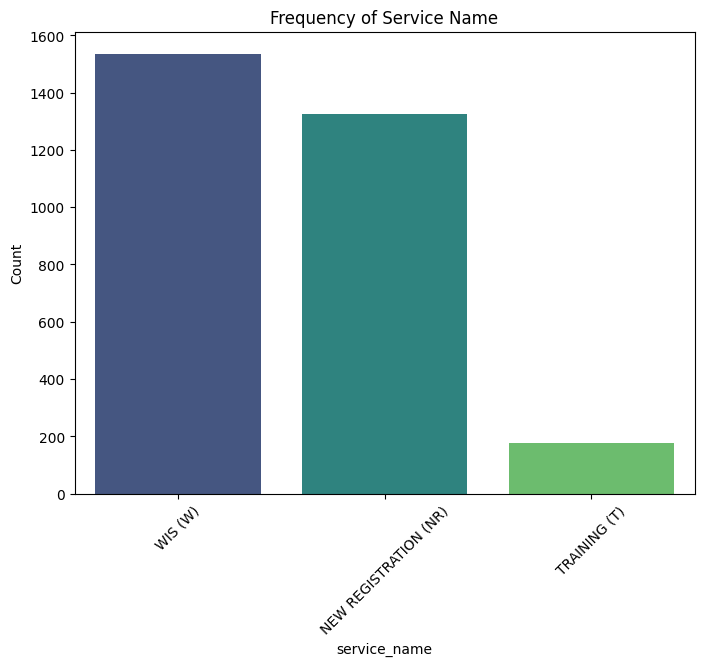

<ipython-input-124-d8deeb1fd20f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


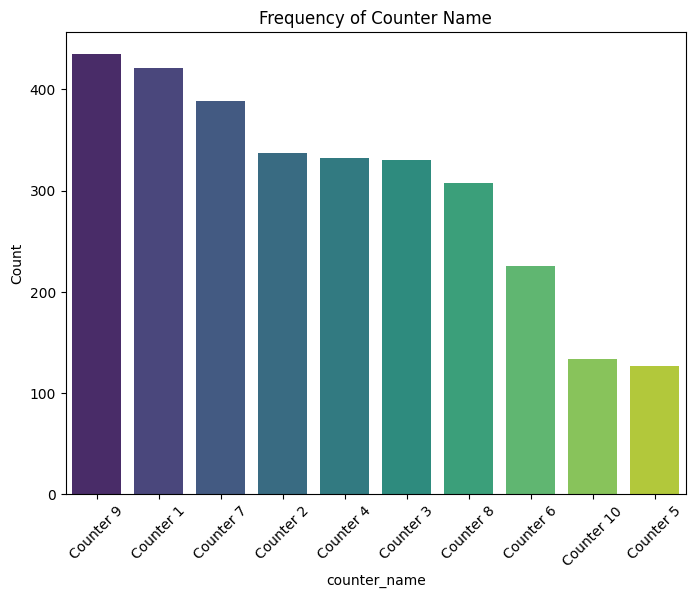

<ipython-input-124-d8deeb1fd20f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


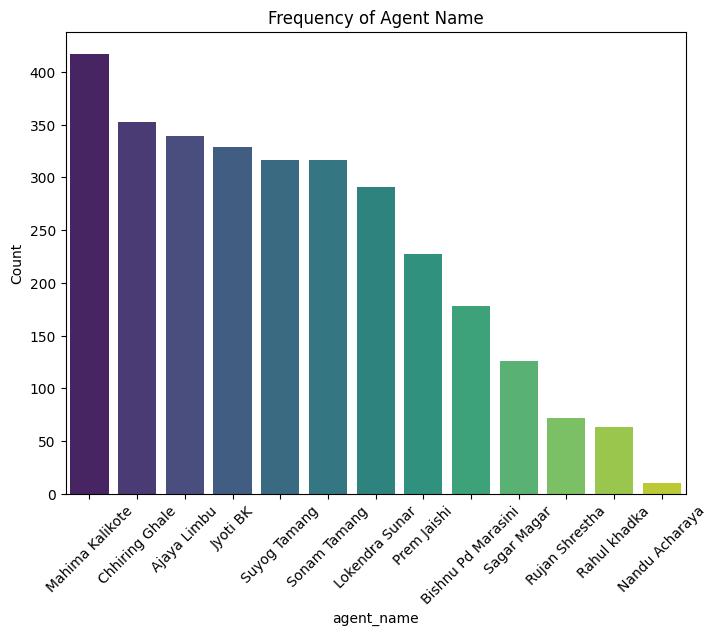

<ipython-input-124-d8deeb1fd20f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


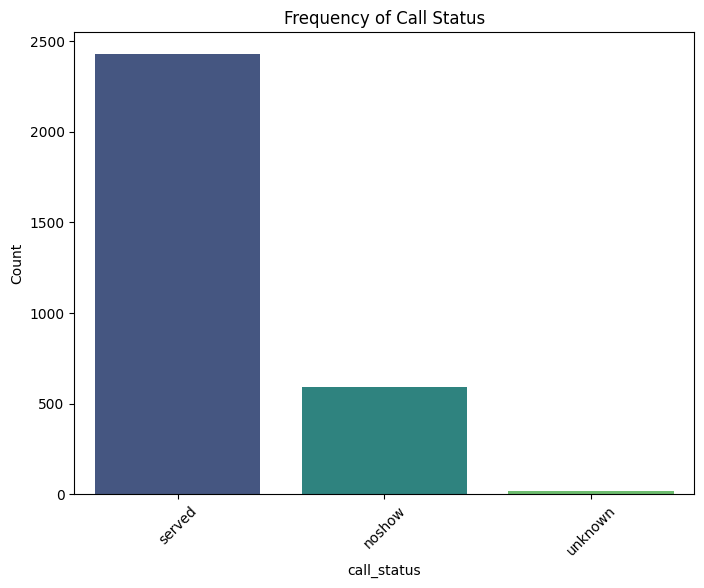

In [124]:
def plot_frequency(column, title):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

plot_frequency('service_name', 'Frequency of Service Name')
plot_frequency('counter_name', 'Frequency of Counter Name')
plot_frequency('agent_name', 'Frequency of Agent Name')
plot_frequency('call_status', 'Frequency of Call Status')

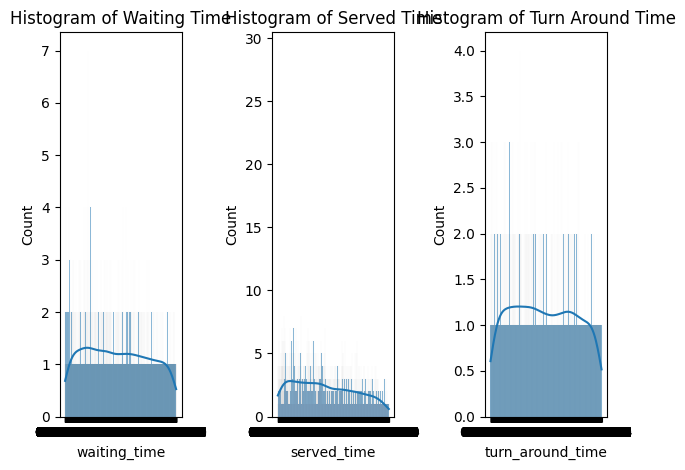

In [125]:
for i, column in enumerate(['waiting_time', 'served_time', 'turn_around_time']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column.replace("_", " ").title()}')
plt.tight_layout()
plt.show()


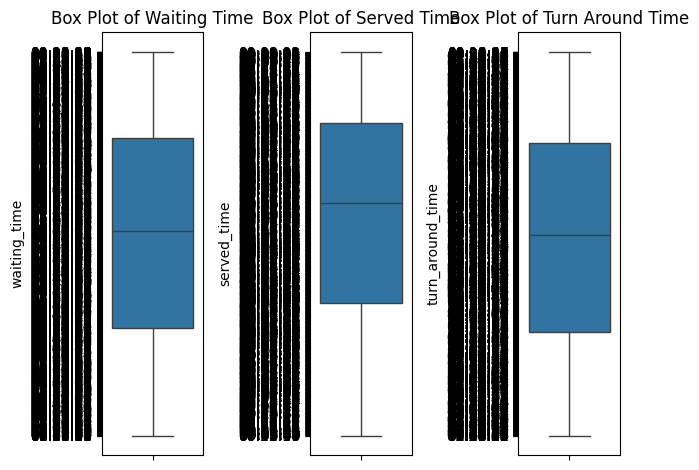

In [126]:
for i, column in enumerate(['waiting_time', 'served_time', 'turn_around_time']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Box Plot of {column.replace("_", " ").title()}')
plt.tight_layout()
plt.show()

In [127]:
data['called_date'].nunique()

20

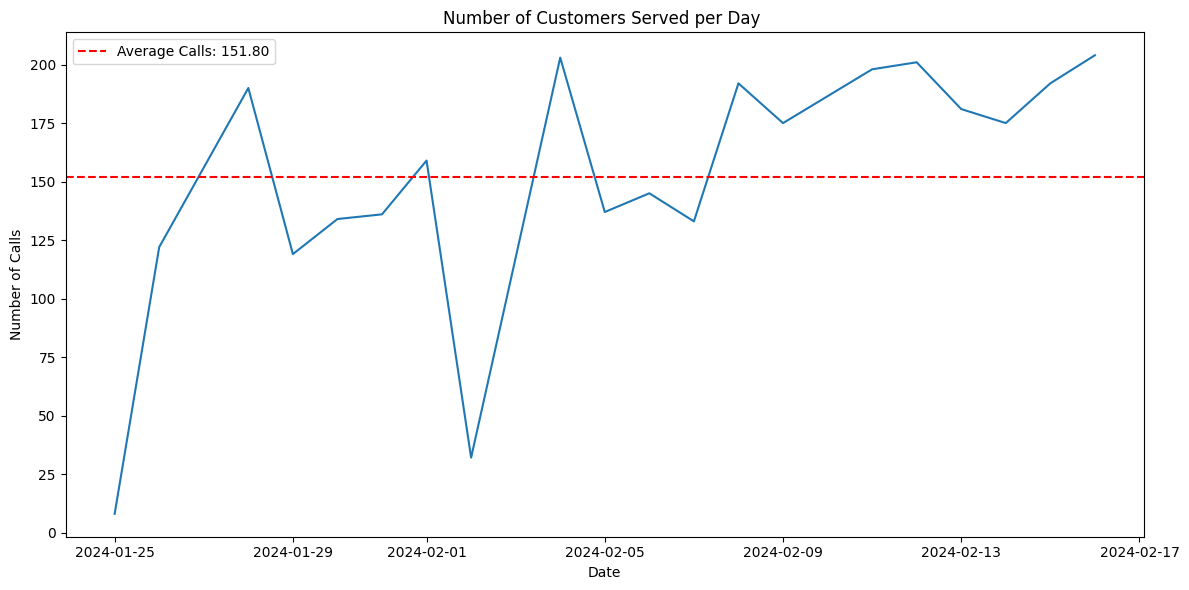

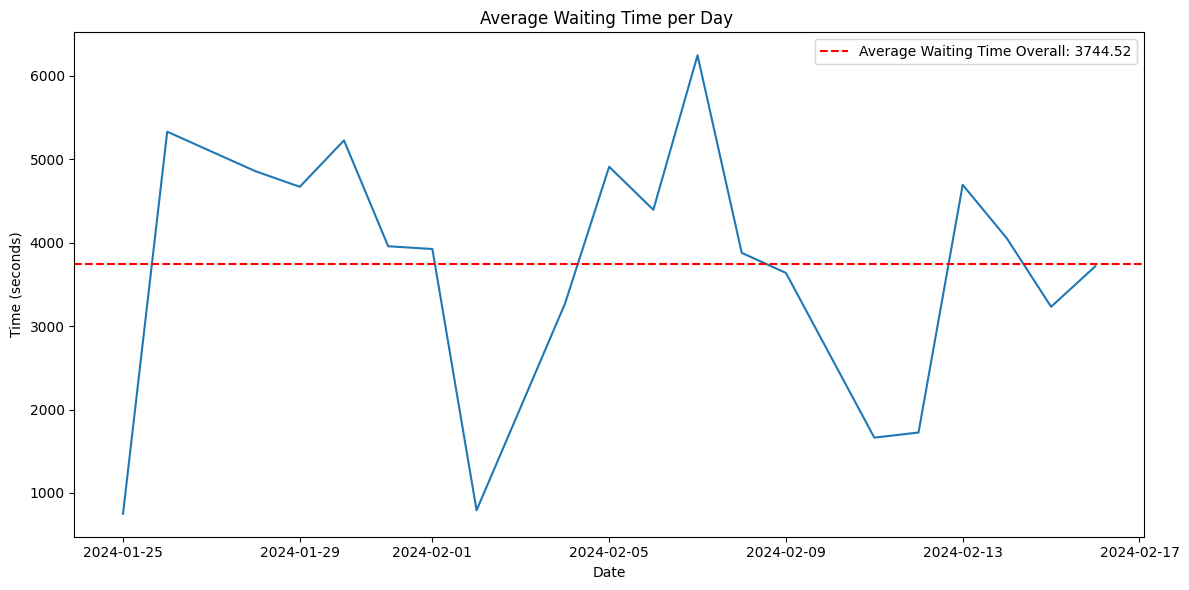

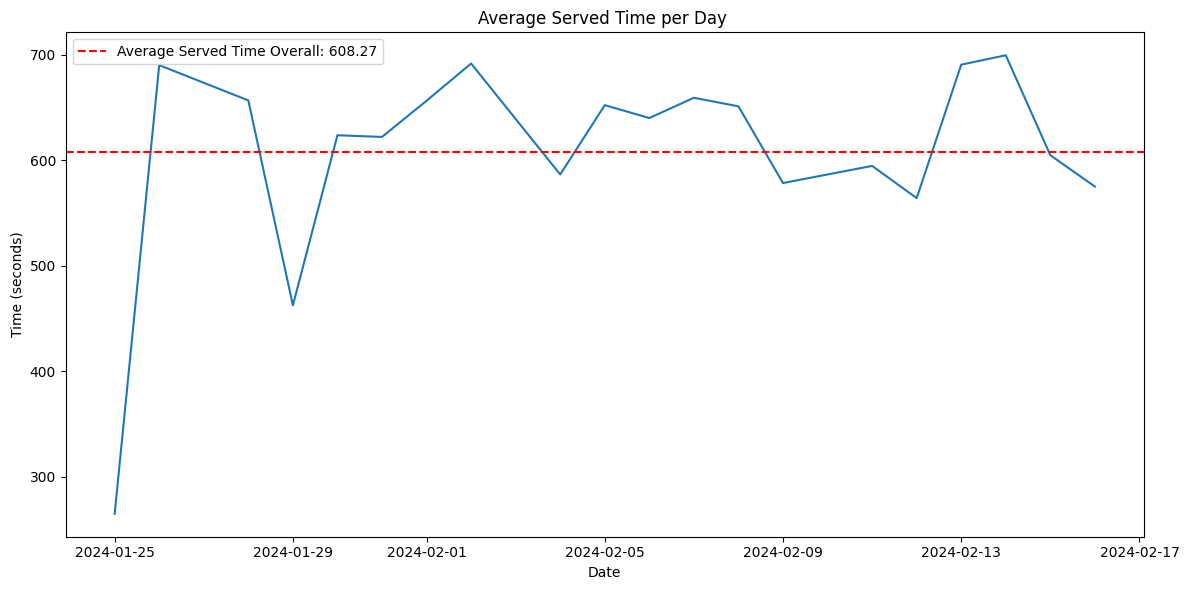

In [128]:
daily_summary = data.groupby('called_date').agg({
    'call_id': 'count',
    'waiting_time_seconds': 'mean',
    'served_time_seconds': 'mean'
}).rename(columns={'call_id': 'number_of_calls'})

def plot_daily_summary(daily_summary, value_col, y_label, title, avg_label, counter=""):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=daily_summary.index, y=daily_summary[value_col])
    average_value = daily_summary[value_col].mean()
    plt.axhline(average_value, color='r', linestyle='--', label=f'{avg_label}: {average_value:.2f}')
    plt.title(title + " " + counter)
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_daily_summary(daily_summary, 'number_of_calls', 'Number of Calls', 'Number of Customers Served per Day', 'Average Calls')
plot_daily_summary(daily_summary, 'waiting_time_seconds', 'Time (seconds)', 'Average Waiting Time per Day', 'Average Waiting Time Overall')
plot_daily_summary(daily_summary, 'served_time_seconds', 'Time (seconds)', 'Average Served Time per Day', 'Average Served Time Overall')


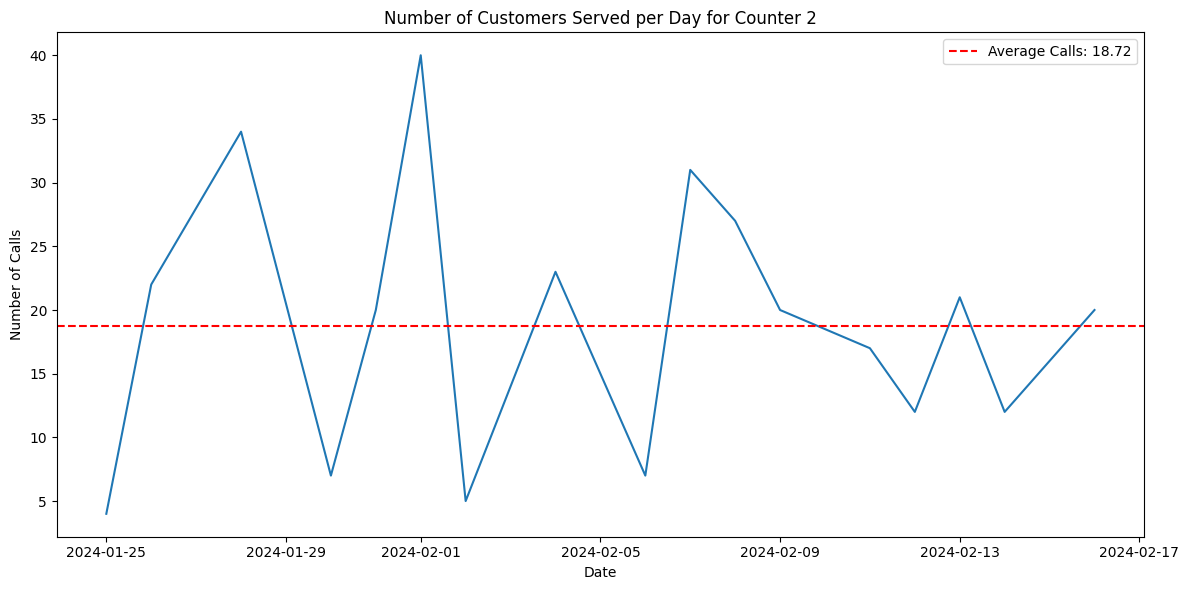

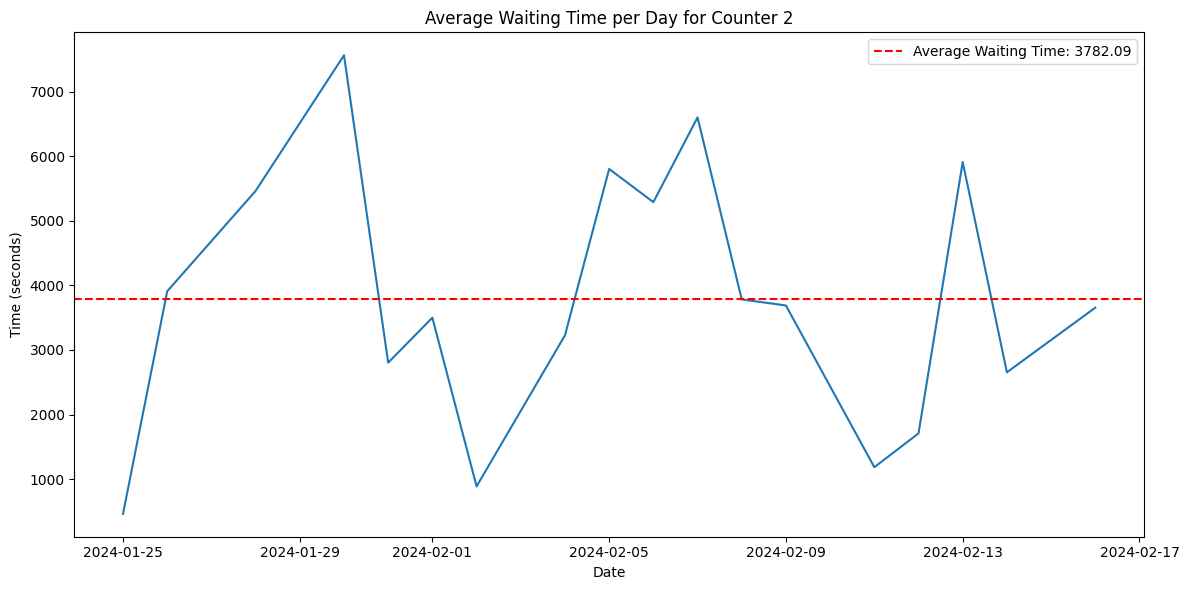

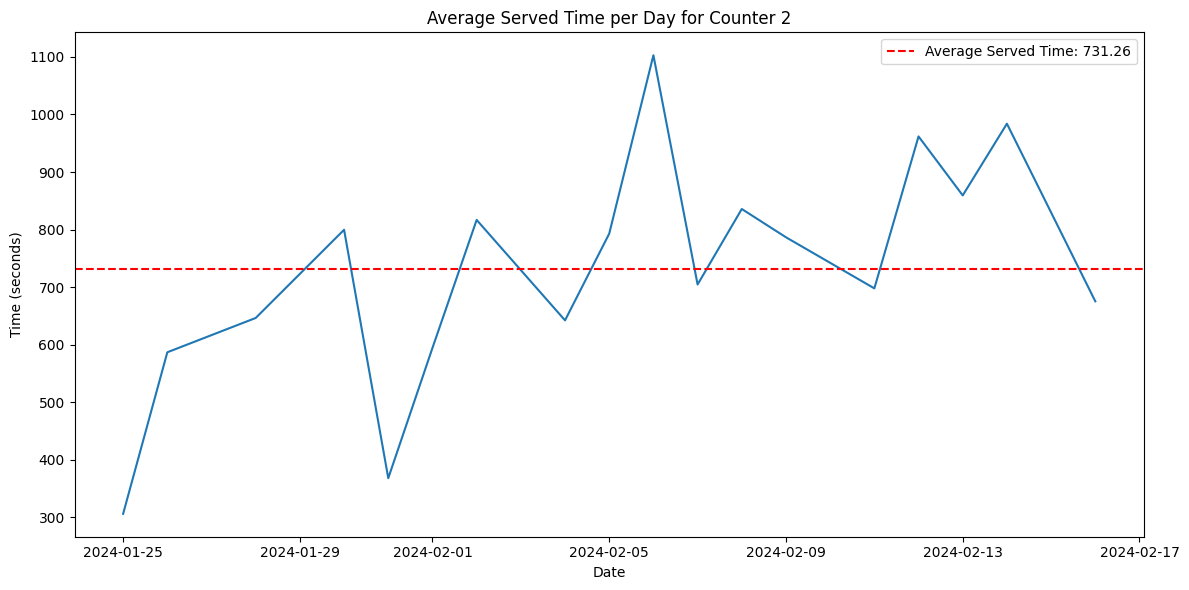

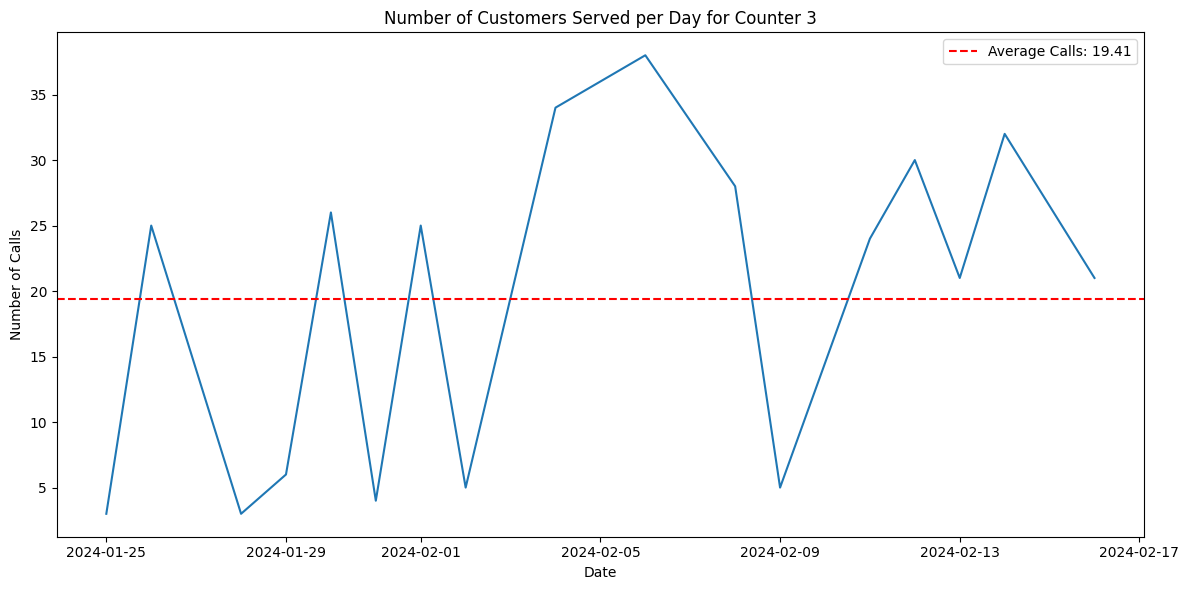

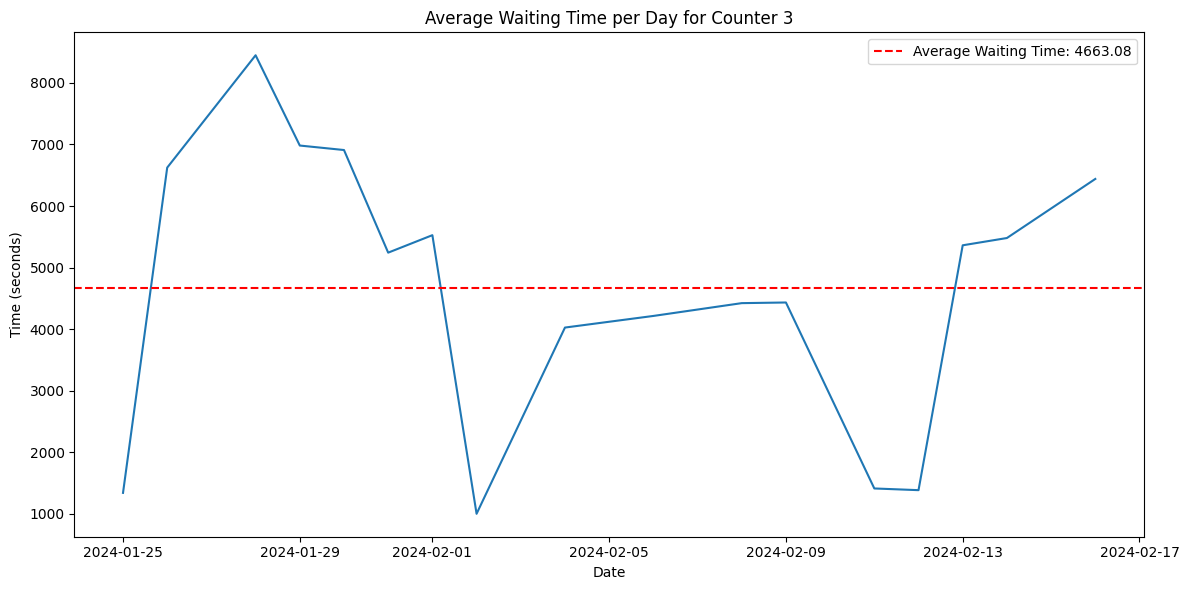

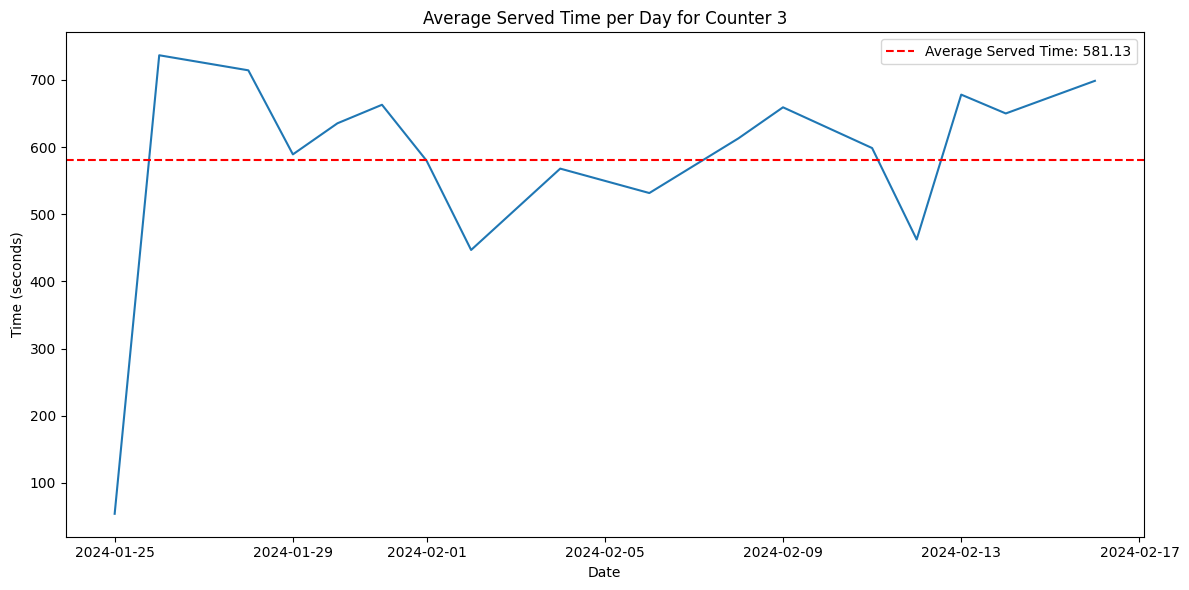

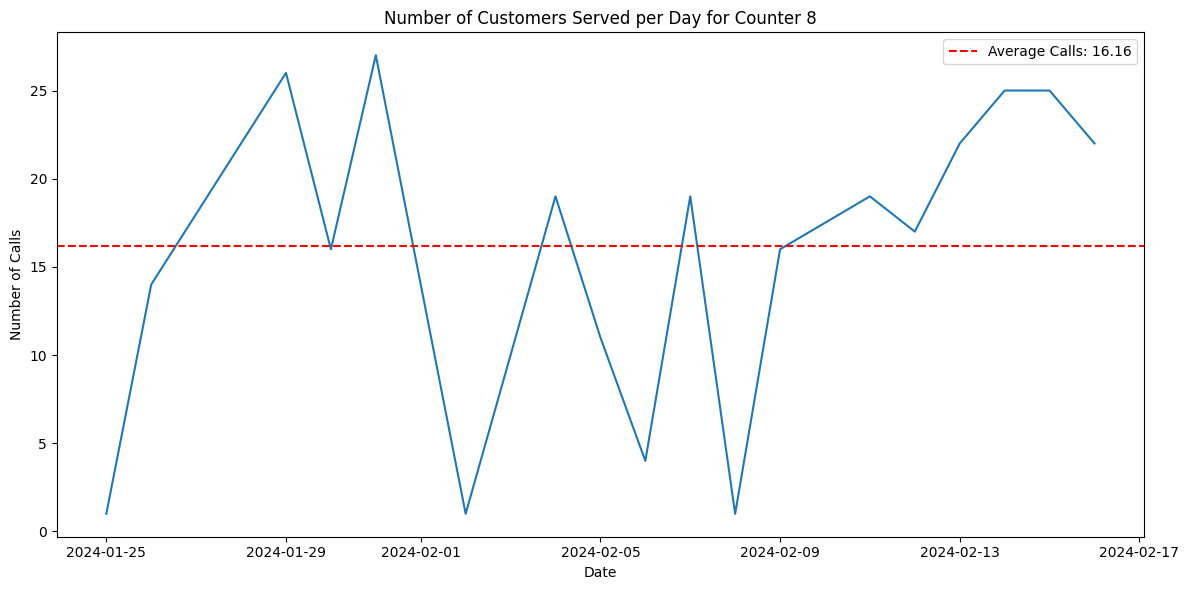

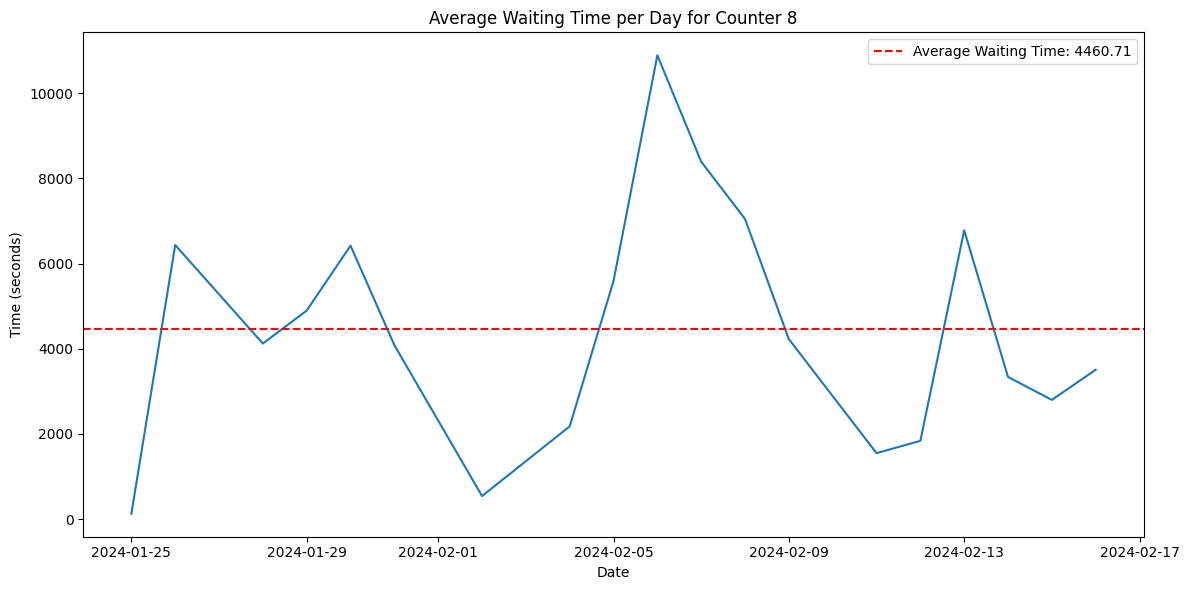

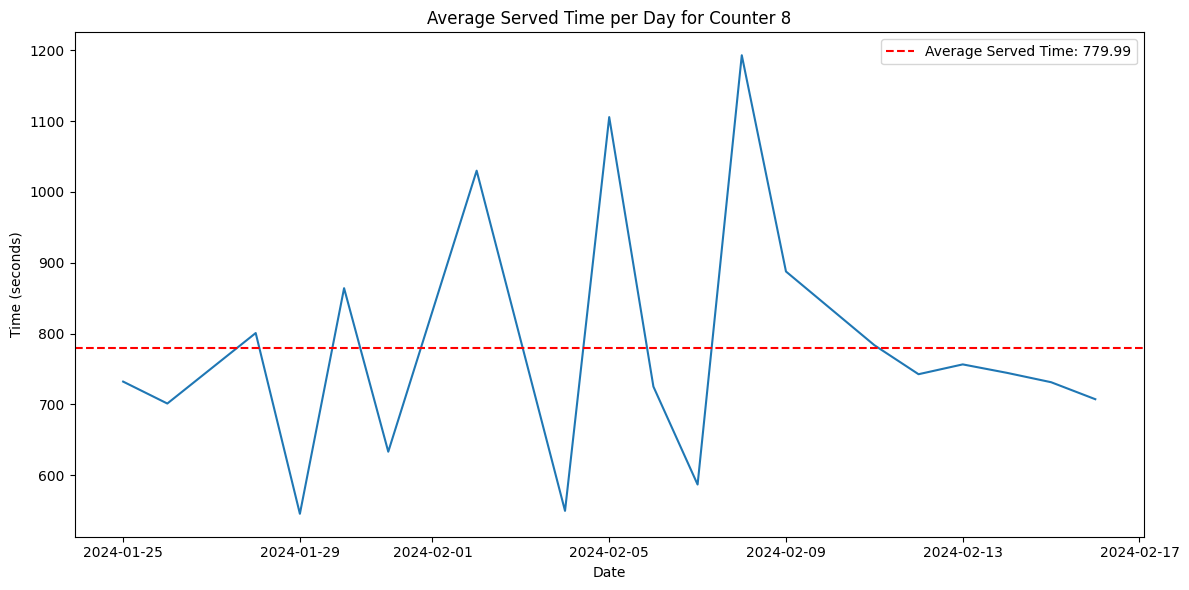

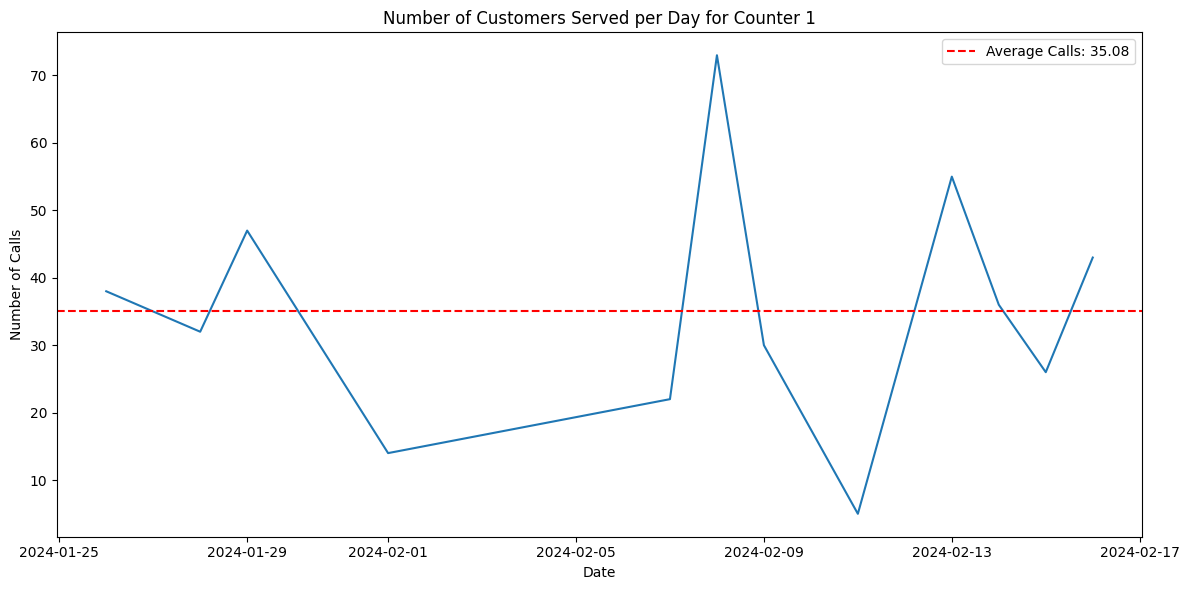

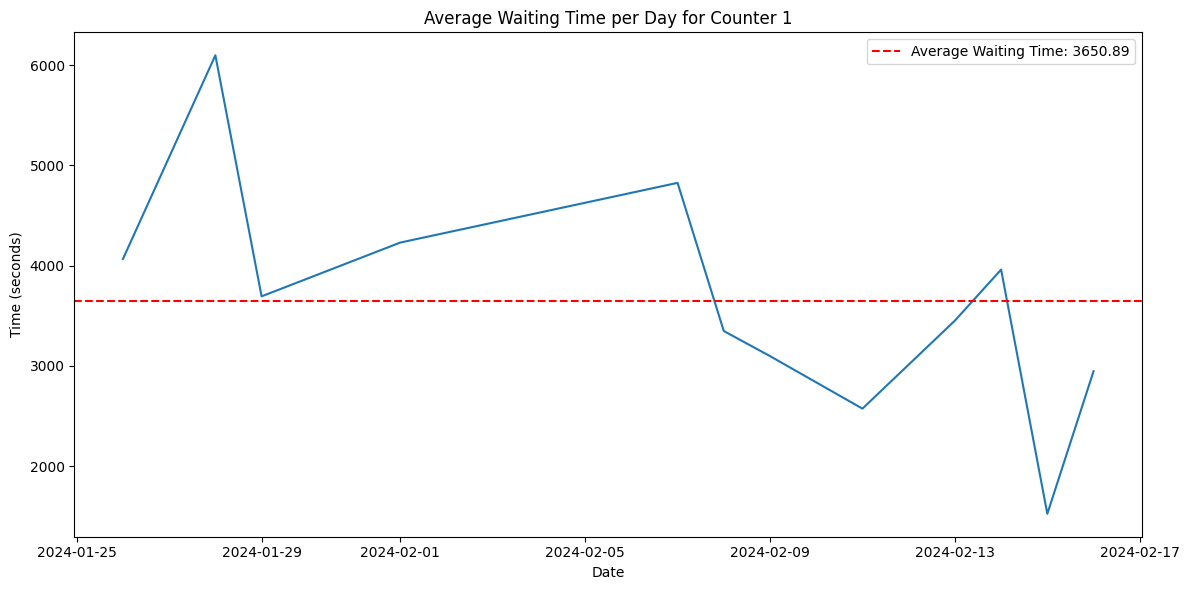

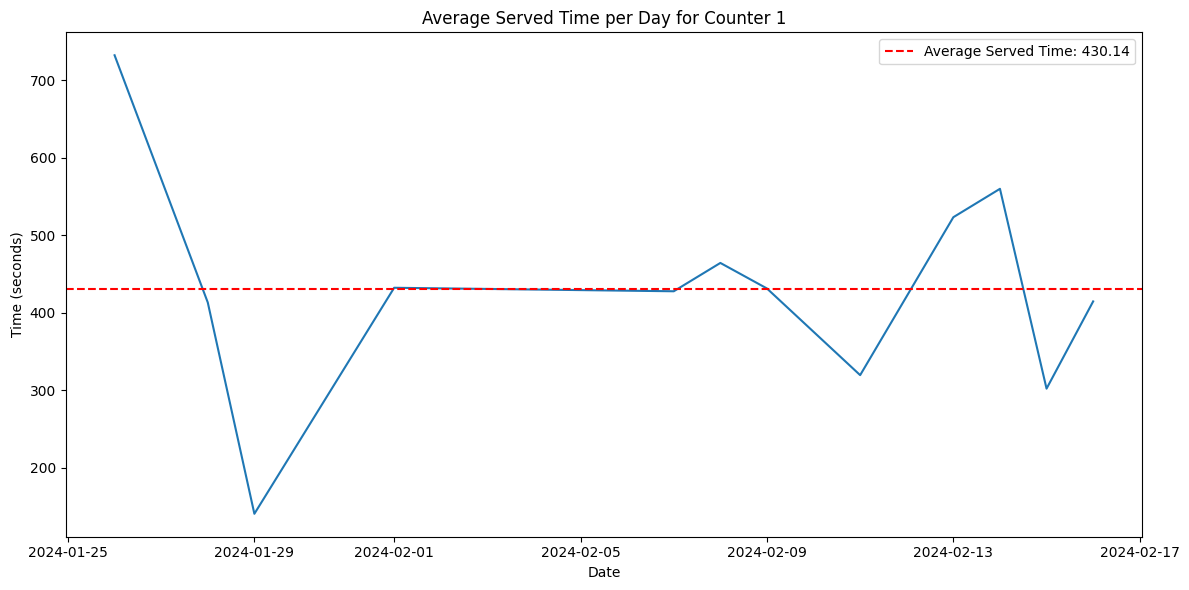

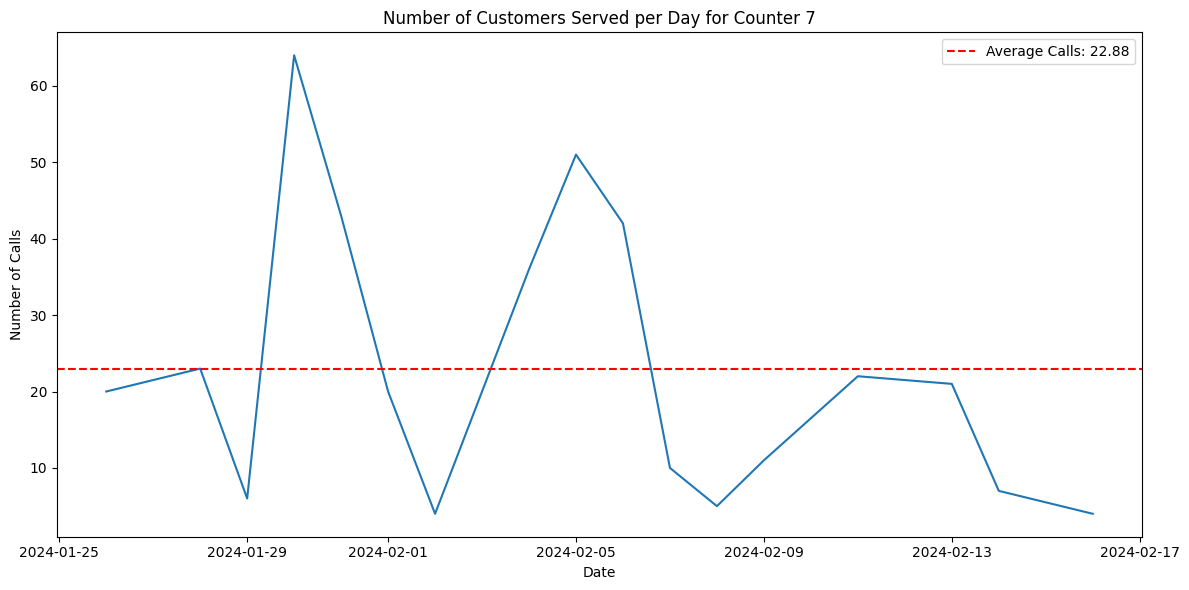

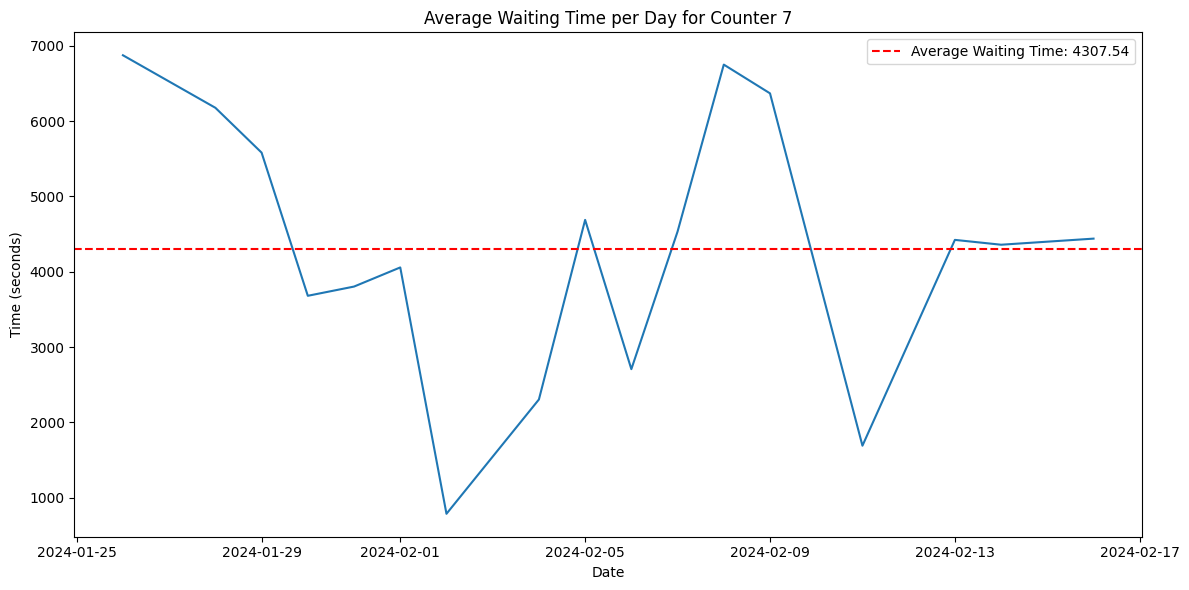

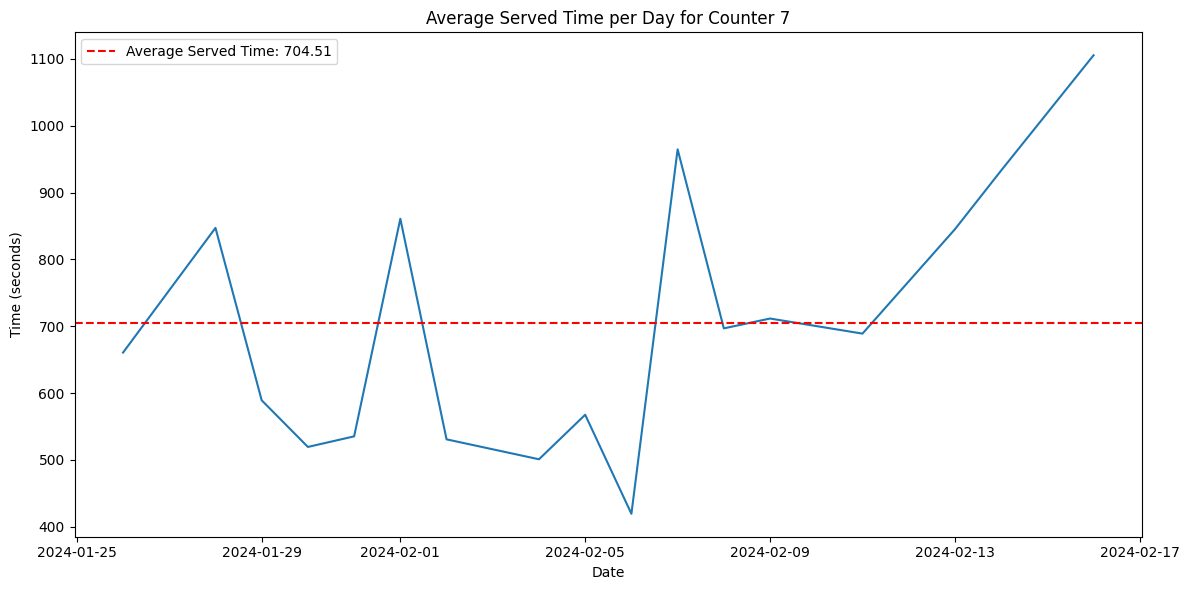

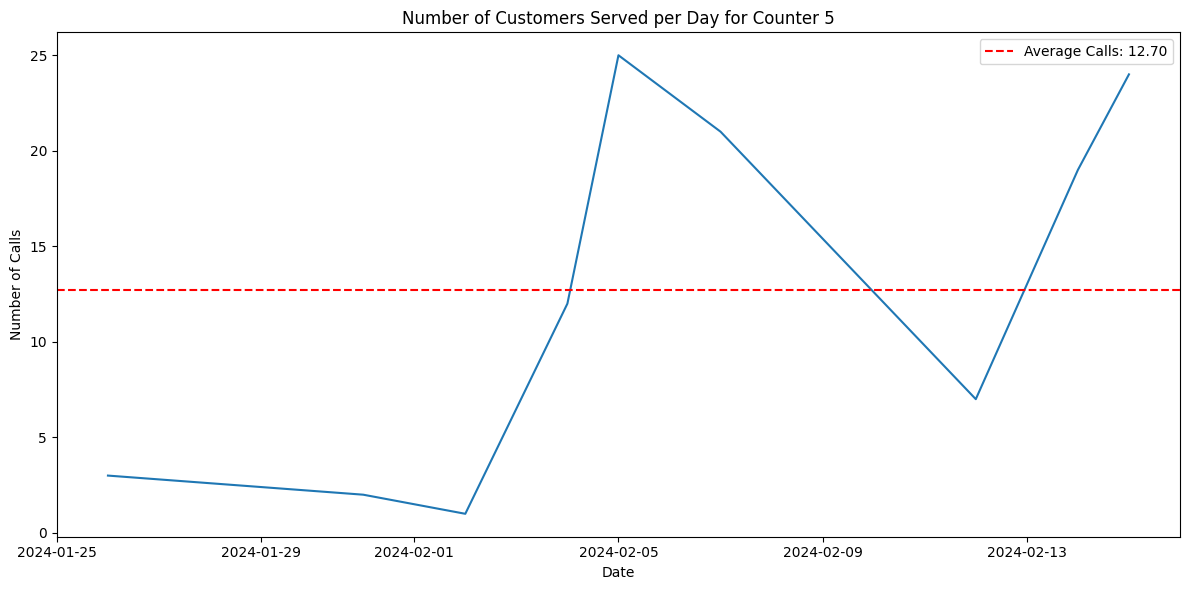

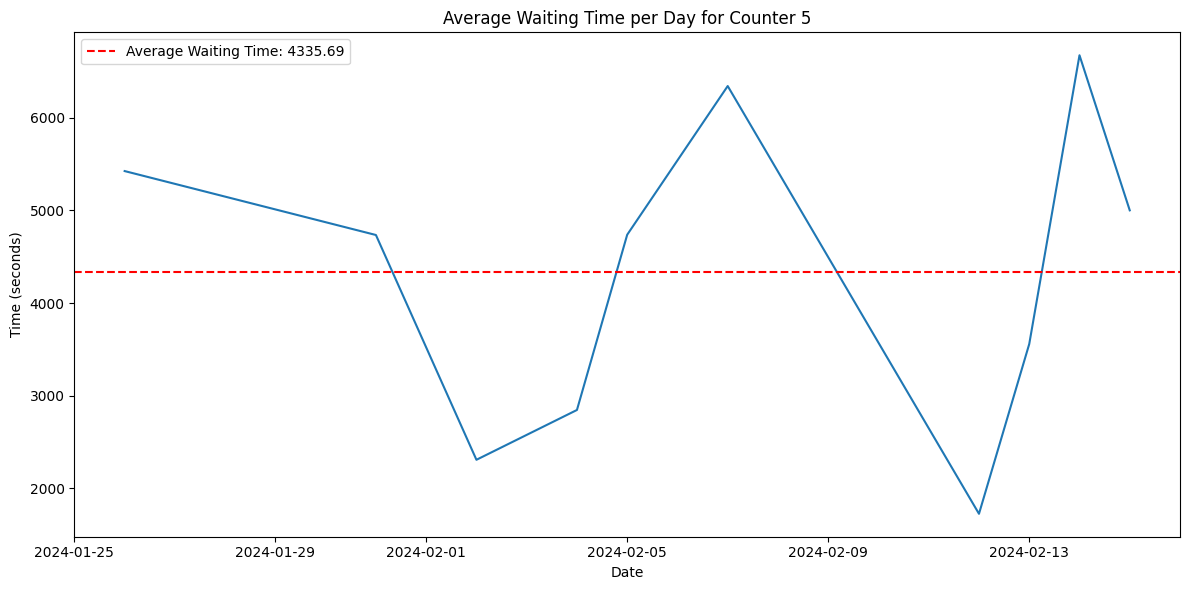

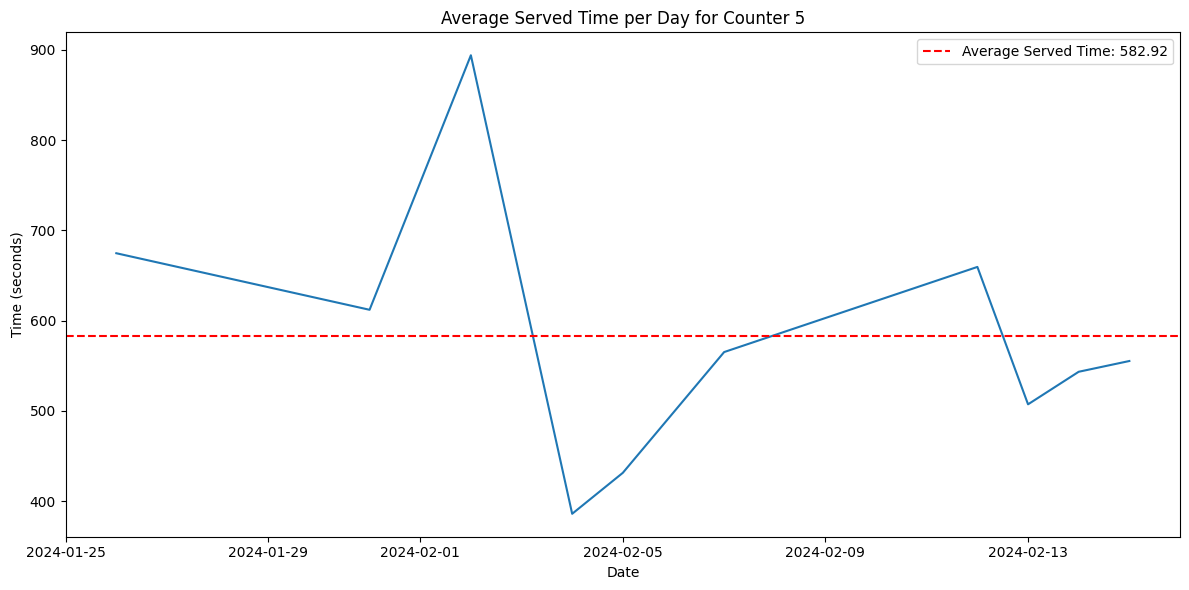

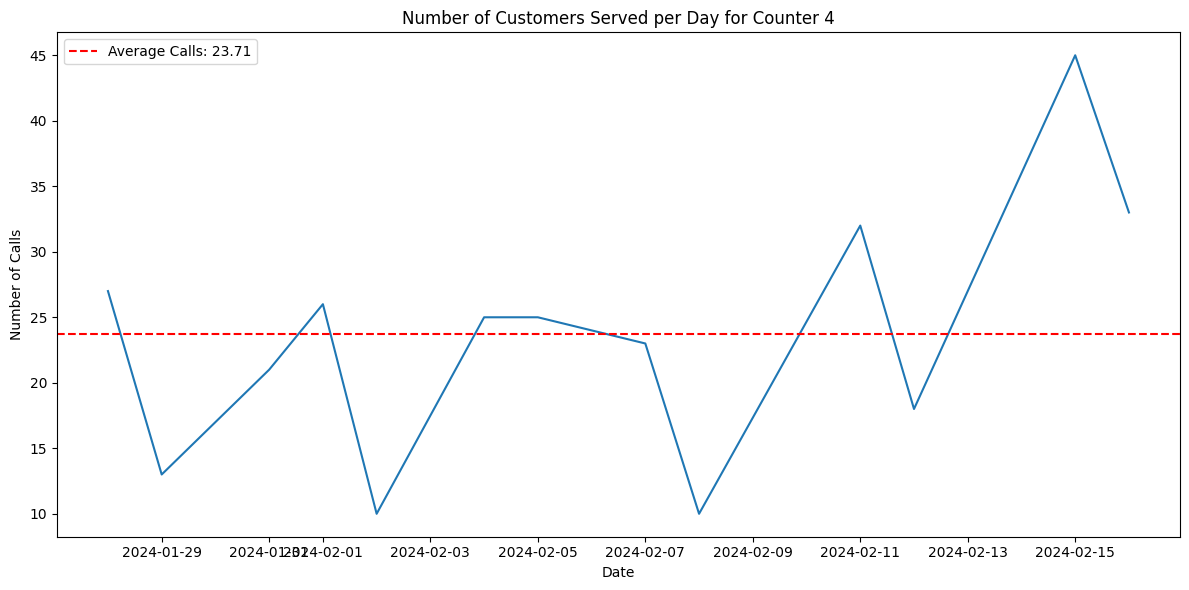

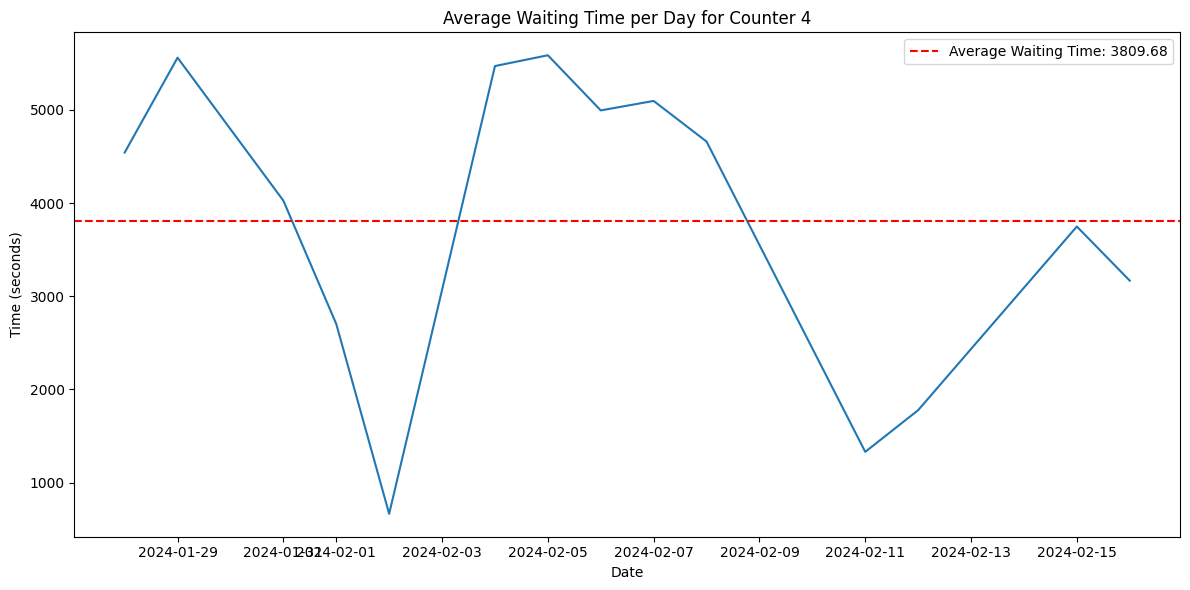

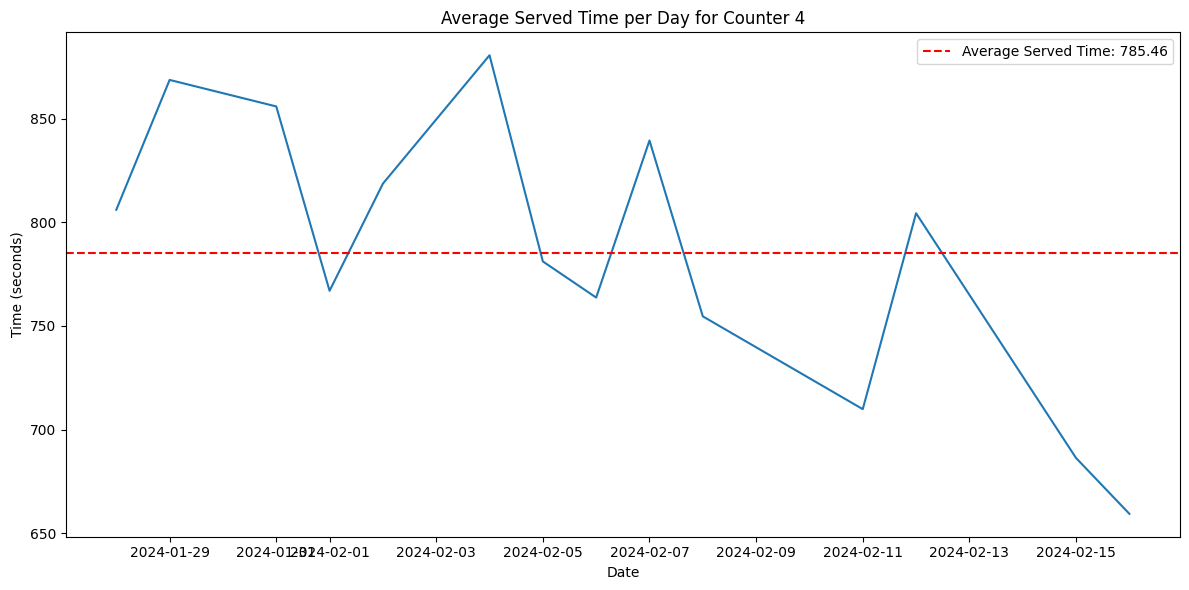

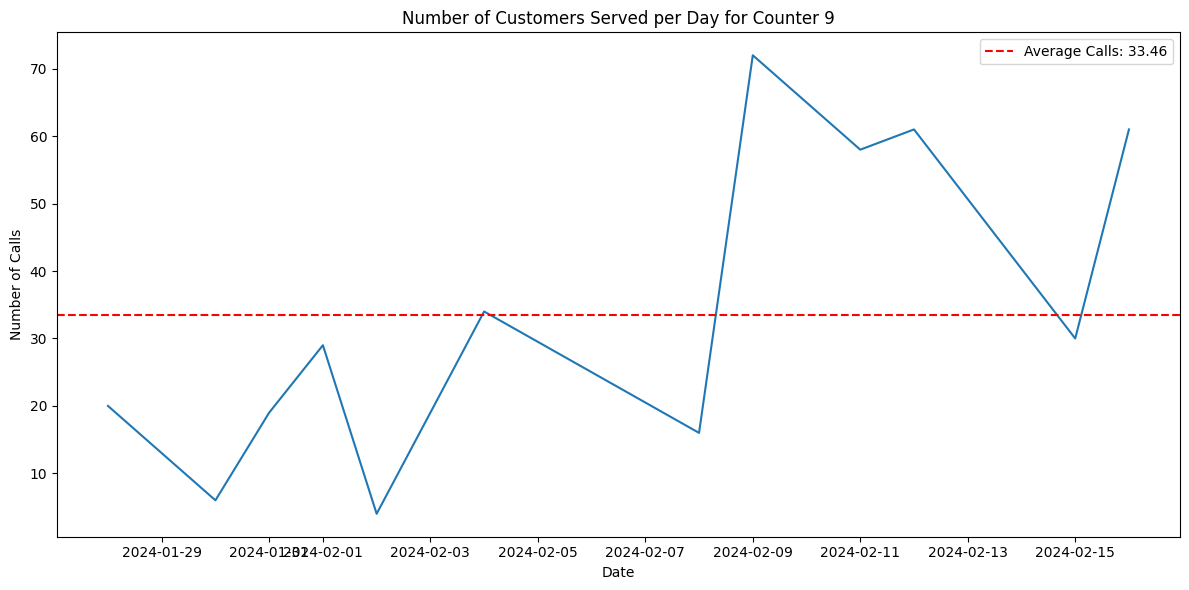

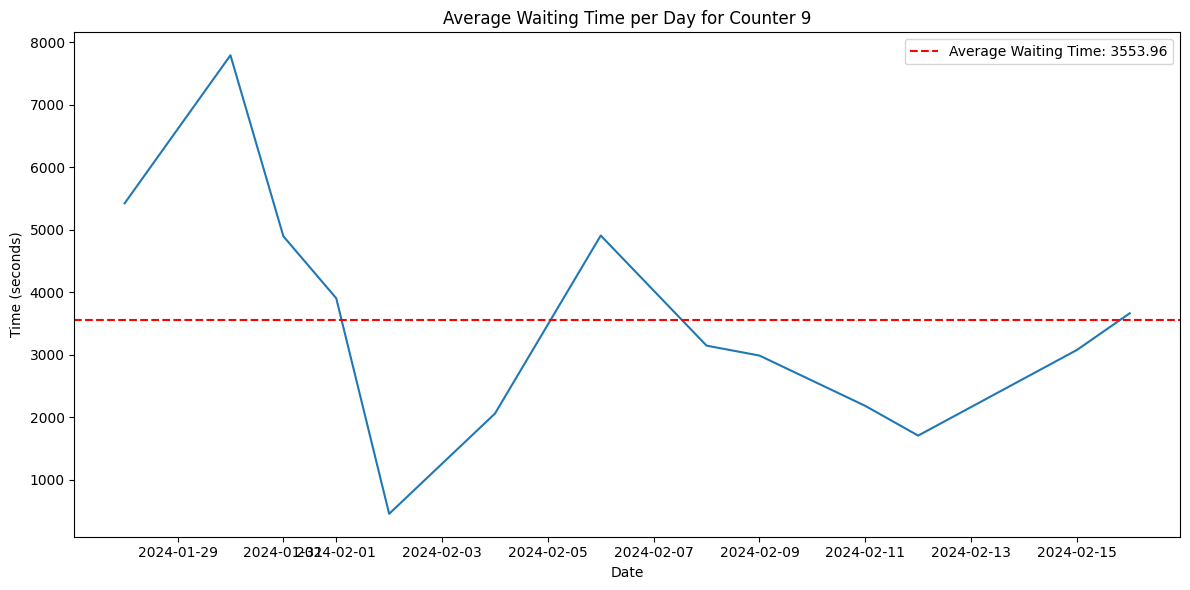

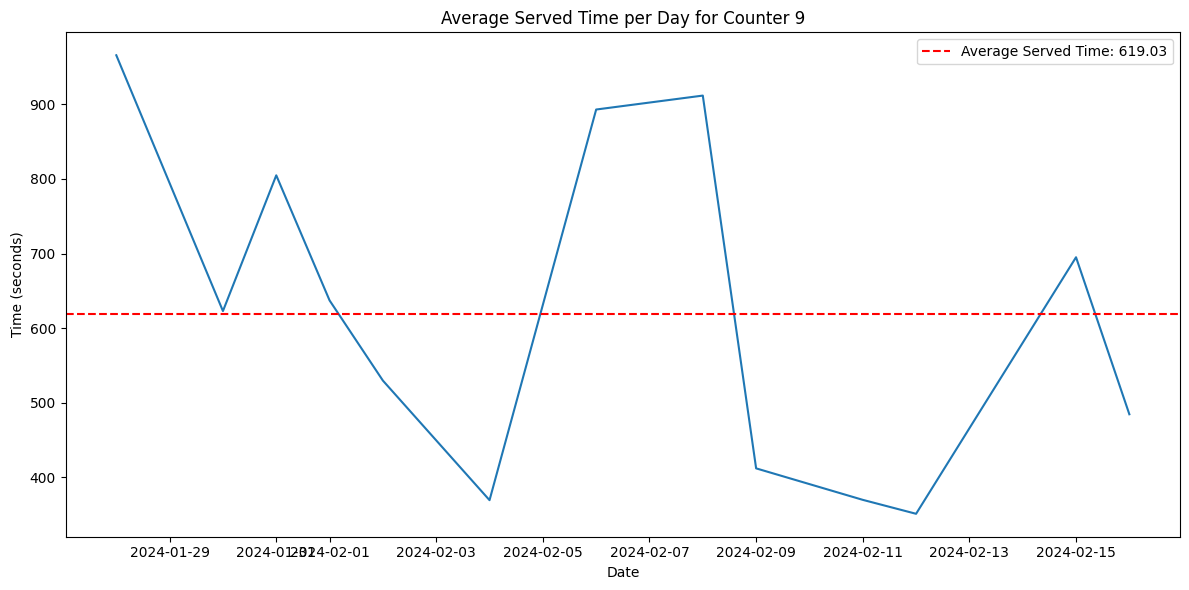

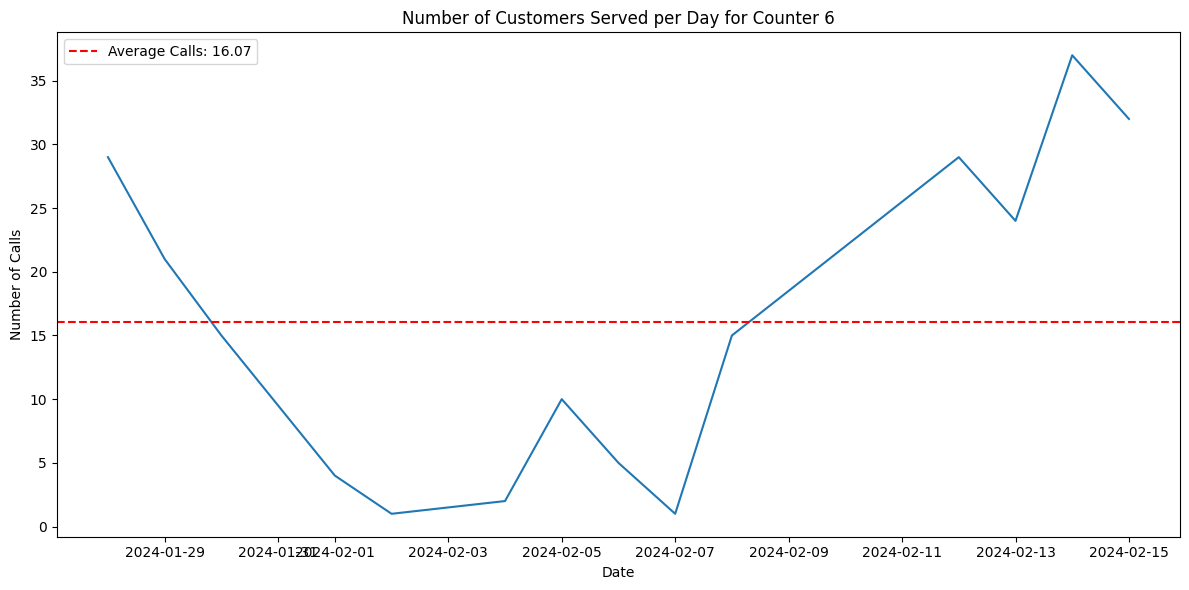

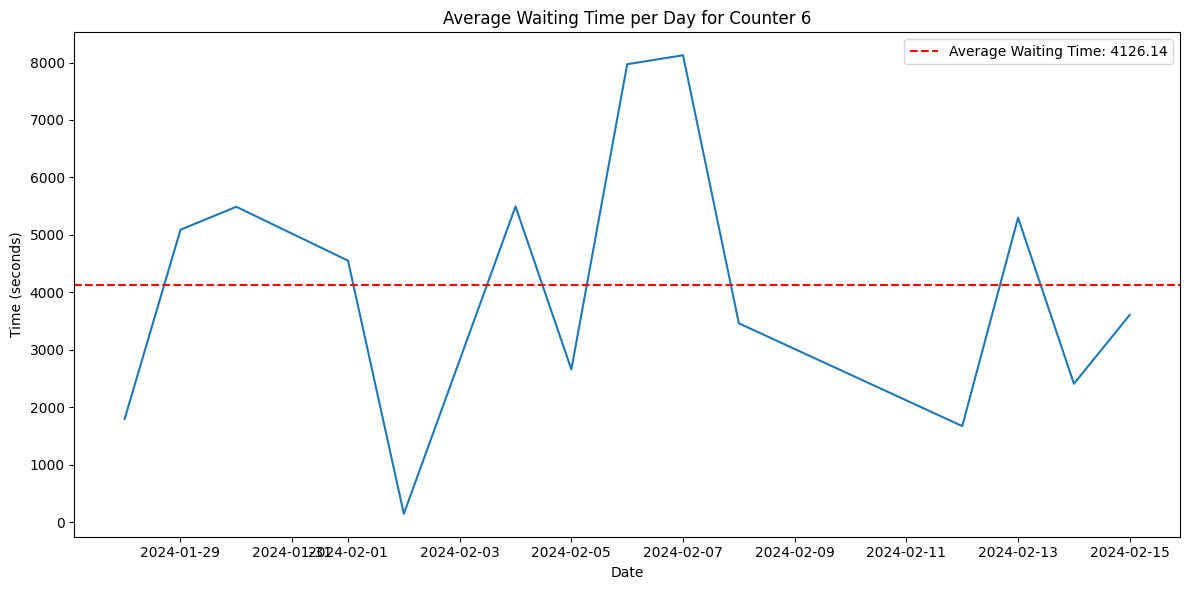

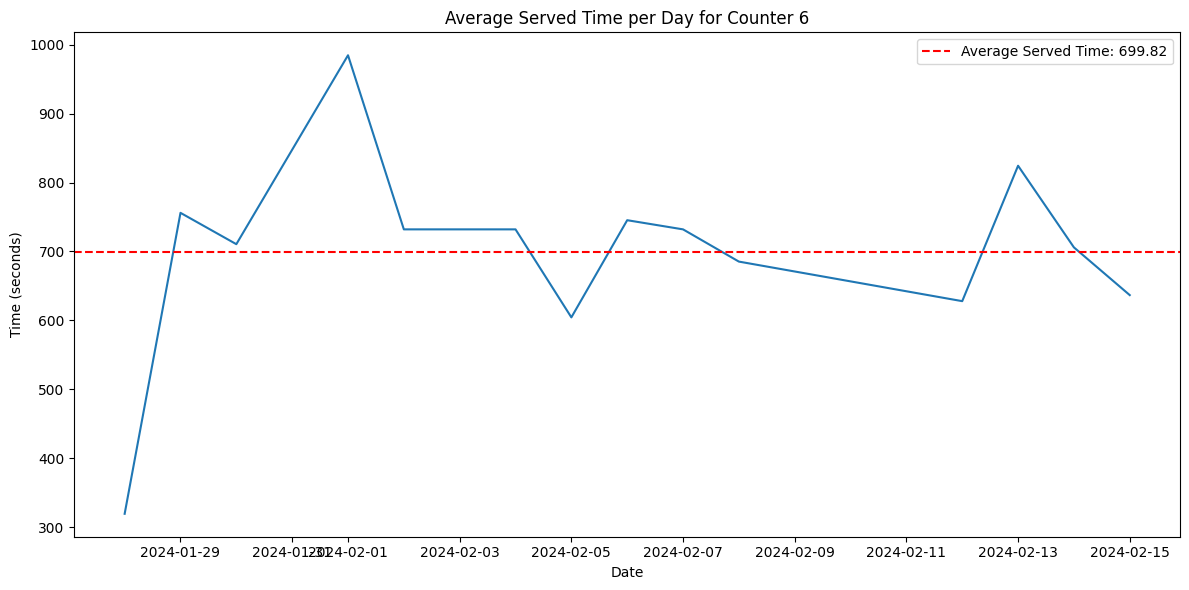

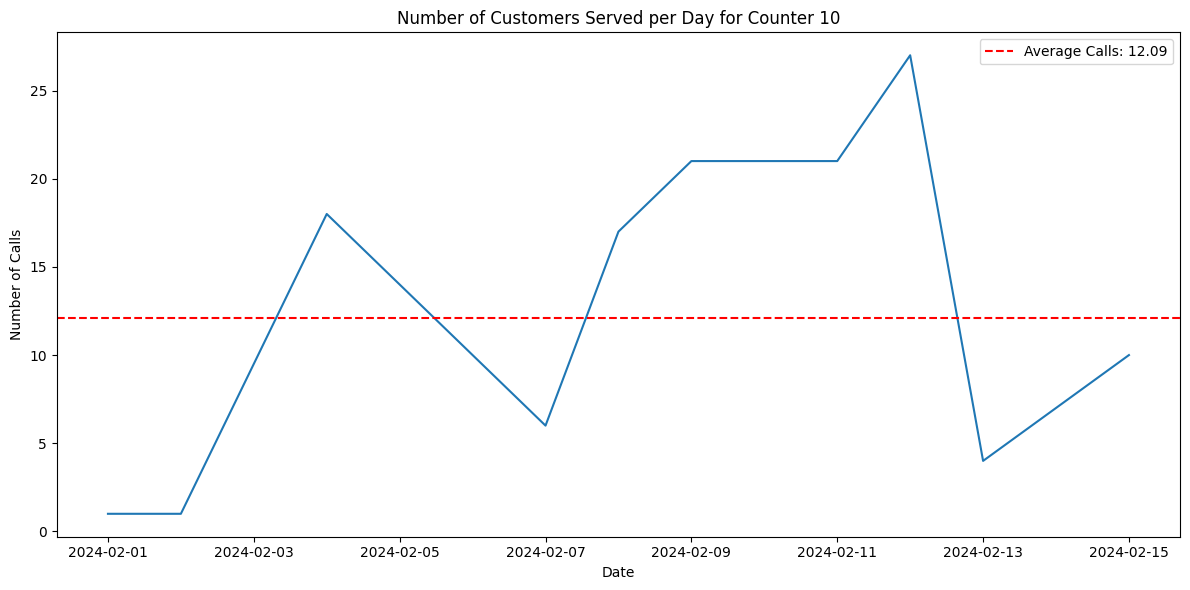

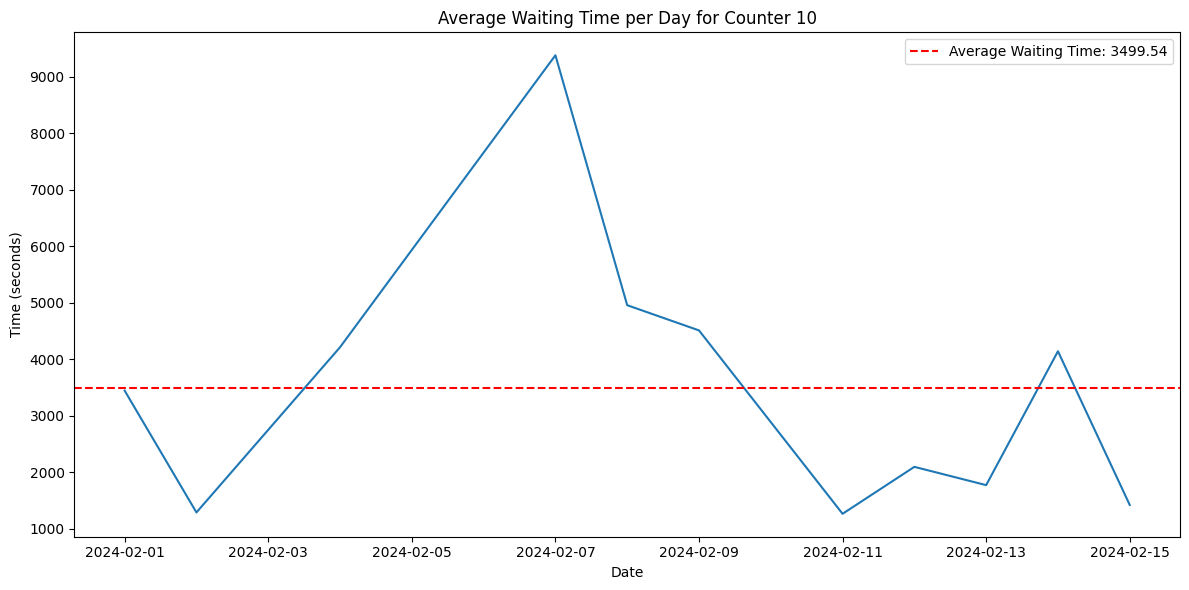

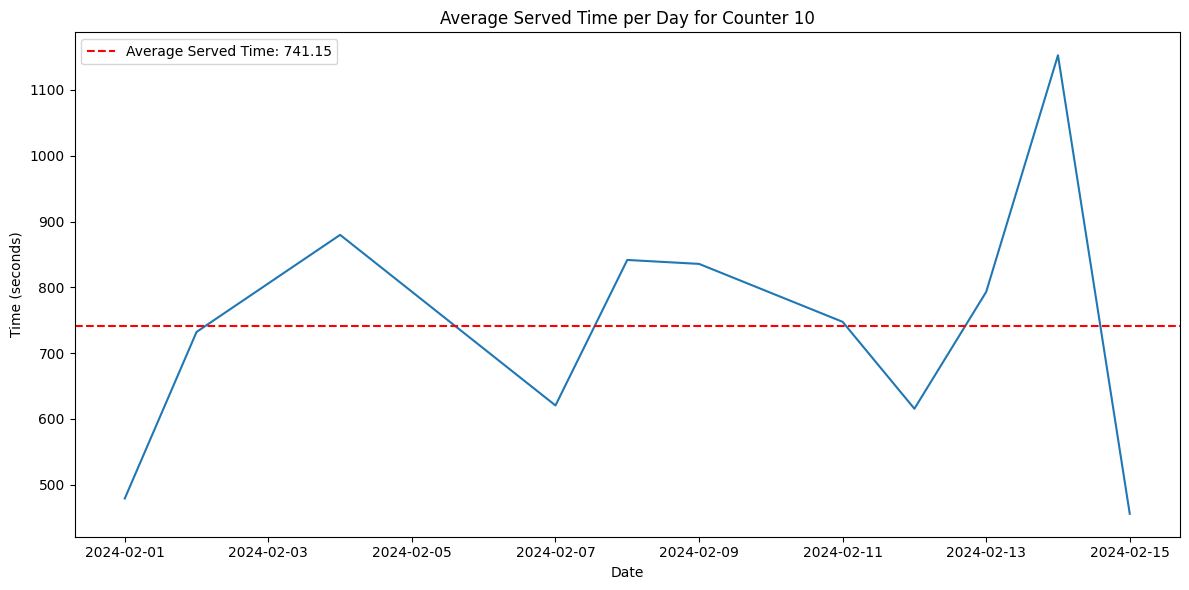

In [129]:
def plot_counter_wise_summary(daily_counter_wise_summary, value_col, y_label, title, avg_label, counter):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=daily_counter_wise_summary.index.get_level_values('called_date'), y=daily_counter_wise_summary[value_col])
    average_value = daily_counter_wise_summary[value_col].mean()
    plt.axhline(average_value, color='r', linestyle='--', label=f'{avg_label}: {average_value:.2f}')
    plt.title(f'{title} for {counter}')
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.show()

daily_counter_wise_summary = data.groupby(['called_date', 'counter_name']).agg({
    'call_id': 'count',
    'waiting_time_seconds': 'mean',
    'served_time_seconds': 'mean'
}).rename(columns={'call_id': 'number_of_calls'})

counters = data['counter_name'].unique()

for counter in counters:
    counter_data = daily_counter_wise_summary.loc[pd.IndexSlice[:, counter], :]

    plot_counter_wise_summary(counter_data, 'number_of_calls', 'Number of Calls', 'Number of Customers Served per Day', 'Average Calls', counter)
    plot_counter_wise_summary(counter_data, 'waiting_time_seconds', 'Time (seconds)', 'Average Waiting Time per Day', 'Average Waiting Time', counter)
    plot_counter_wise_summary(counter_data, 'served_time_seconds', 'Time (seconds)', 'Average Served Time per Day', 'Average Served Time', counter)


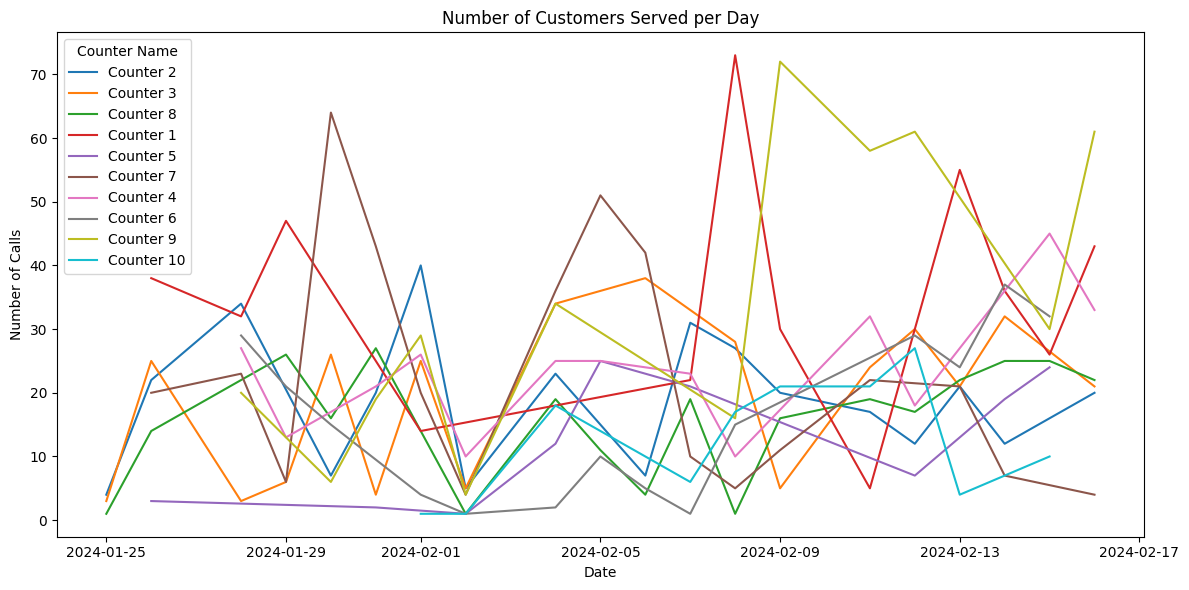

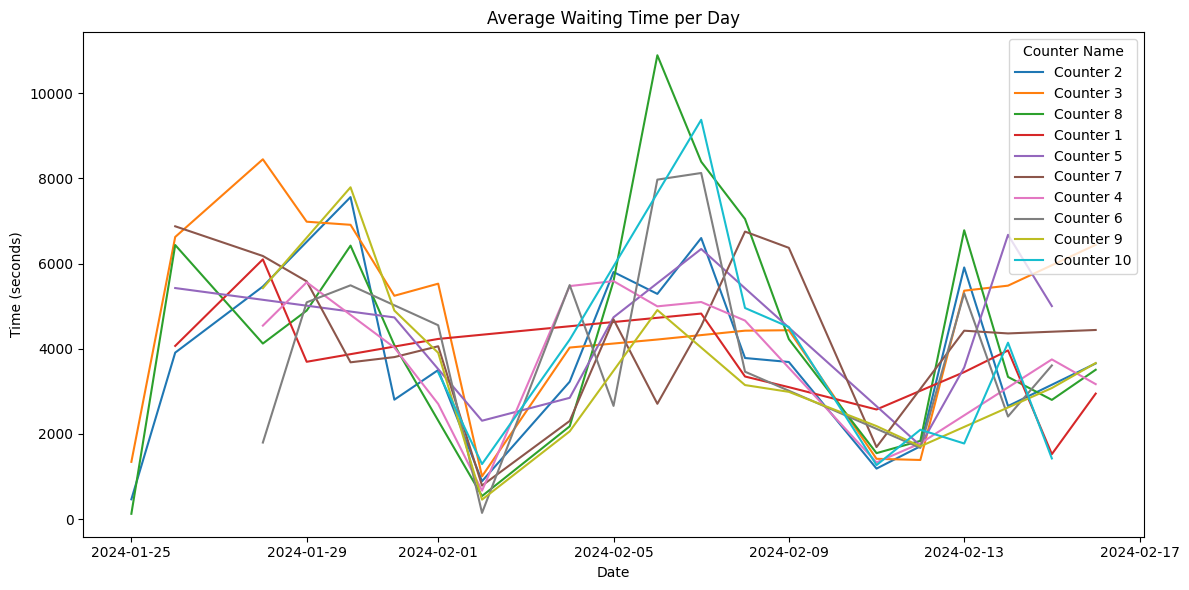

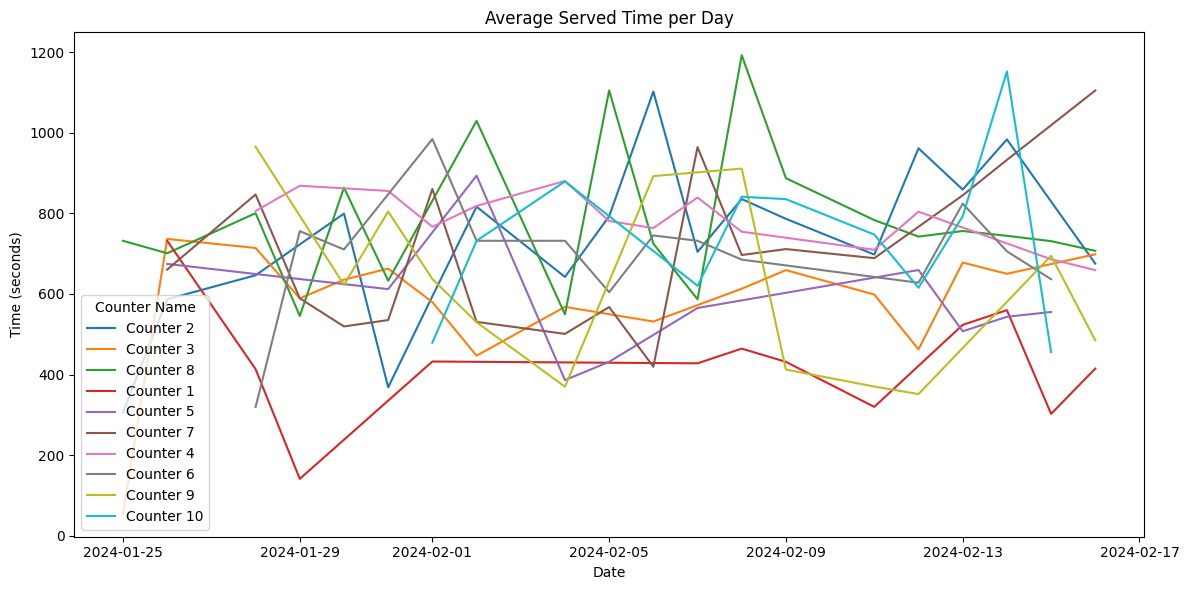

In [141]:
def plot_counter_summary_v2(daily_counter_wise_summary, value_col, y_label, title):
    daily_counter_wise_summary = daily_counter_wise_summary.reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=daily_counter_wise_summary, x='called_date', y=value_col, hue='counter_name')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.legend(title='Counter Name')
    plt.tight_layout()
    plt.show()

daily_counter_wise_summary = data.groupby(['called_date', 'counter_name']).agg({
    'call_id': 'count',
    'waiting_time_seconds': 'mean',
    'served_time_seconds': 'mean'
}).rename(columns={'call_id': 'number_of_calls'})

plot_counter_summary_v2(daily_counter_wise_summary, 'number_of_calls', 'Number of Calls', 'Number of Customers Served per Day')
plot_counter_summary_v2(daily_counter_wise_summary, 'waiting_time_seconds', 'Time (seconds)', 'Average Waiting Time per Day')
plot_counter_summary_v2(daily_counter_wise_summary, 'served_time_seconds', 'Time (seconds)', 'Average Served Time per Day')


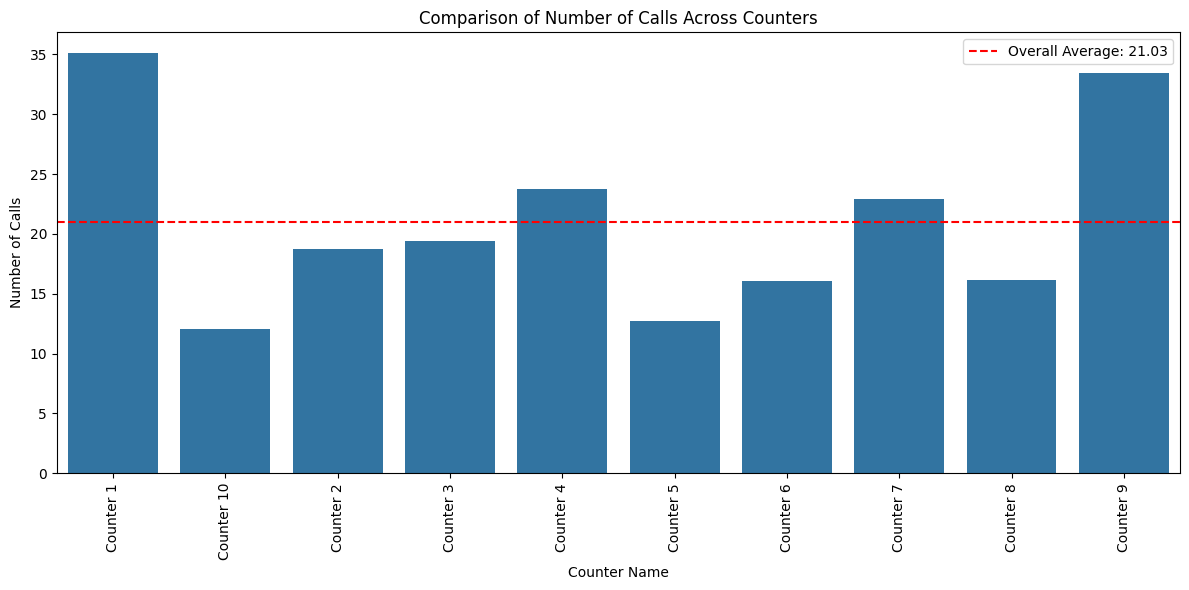

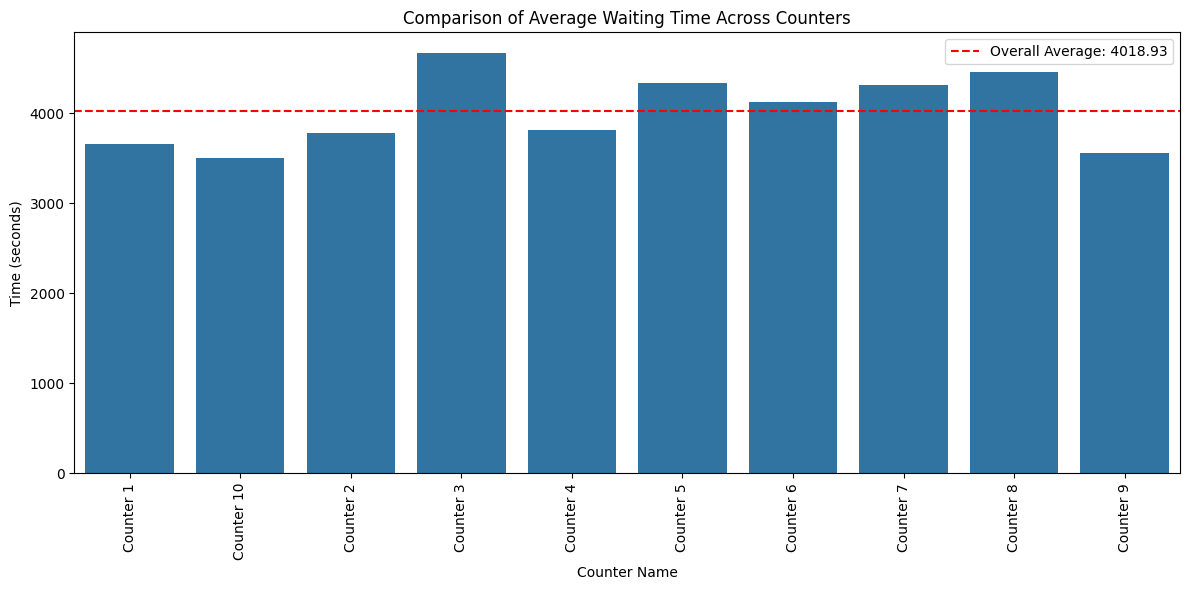

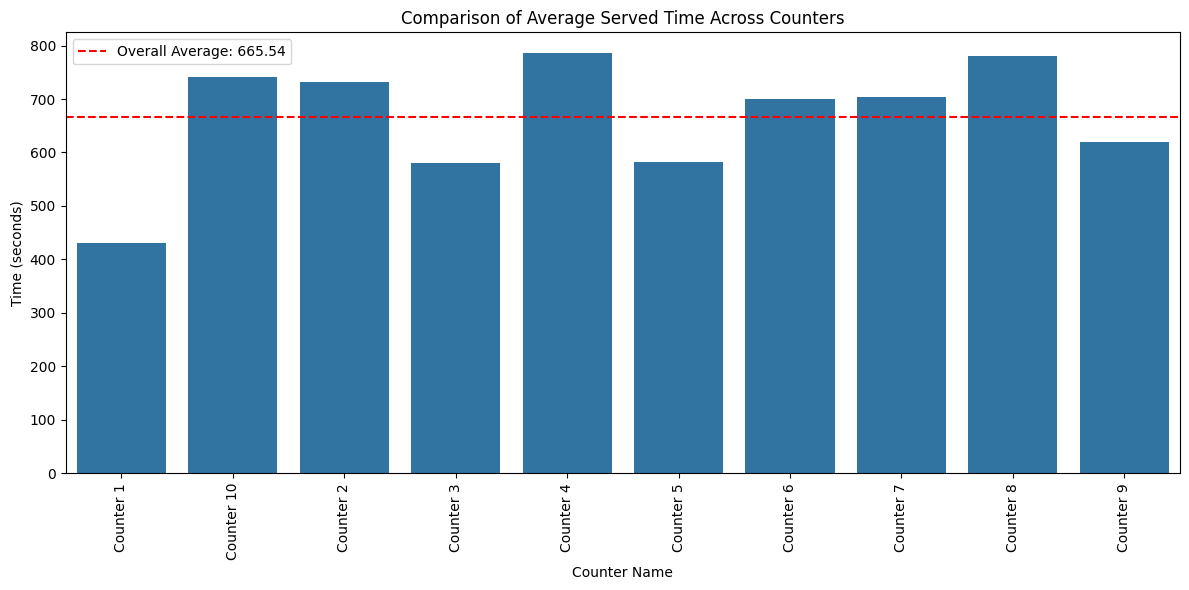

In [130]:
def plot_comparison_overall_avg(daily_counter_wise_summary, value_col, y_label, title, avg_label, service = False):
    plt.figure(figsize=(12, 6))
    avg_per_counter = daily_counter_wise_summary.groupby(level=1)[value_col].mean()
    sns.barplot(x=avg_per_counter.index, y=avg_per_counter.values)
    plt.title(title)
    if service:
      plt.xlabel('Service Name')
    else:
      plt.xlabel('Counter Name')
    plt.ylabel(y_label)
    plt.axhline(avg_per_counter.mean(), color='r', linestyle='--', label=f'Overall Average: {avg_per_counter.mean():.2f}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_comparison_overall_avg(daily_counter_wise_summary, 'number_of_calls', 'Number of Calls', 'Comparison of Number of Calls Across Counters', 'Average Calls')
plot_comparison_overall_avg(daily_counter_wise_summary, 'waiting_time_seconds', 'Time (seconds)', 'Comparison of Average Waiting Time Across Counters', 'Average Waiting Time')
plot_comparison_overall_avg(daily_counter_wise_summary, 'served_time_seconds', 'Time (seconds)', 'Comparison of Average Served Time Across Counters', 'Average Served Time')


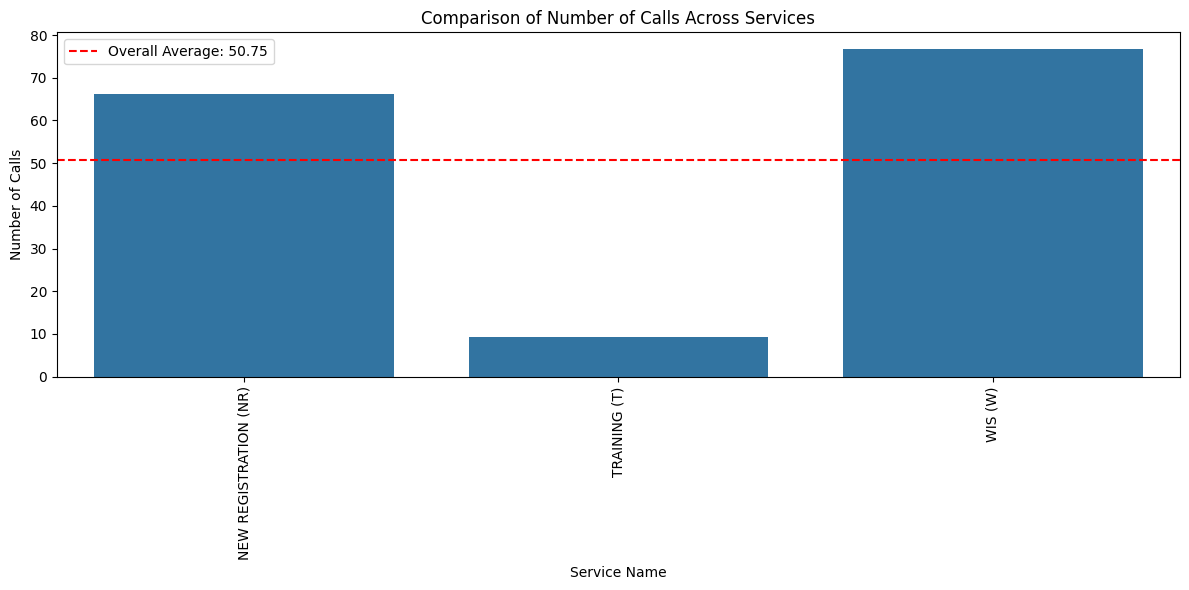

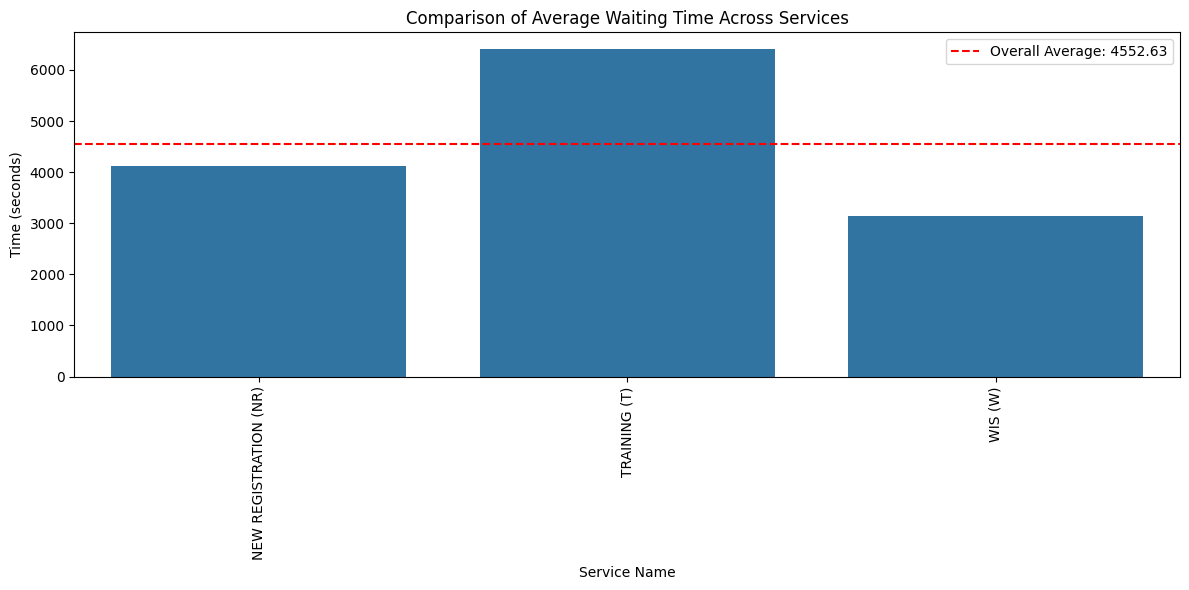

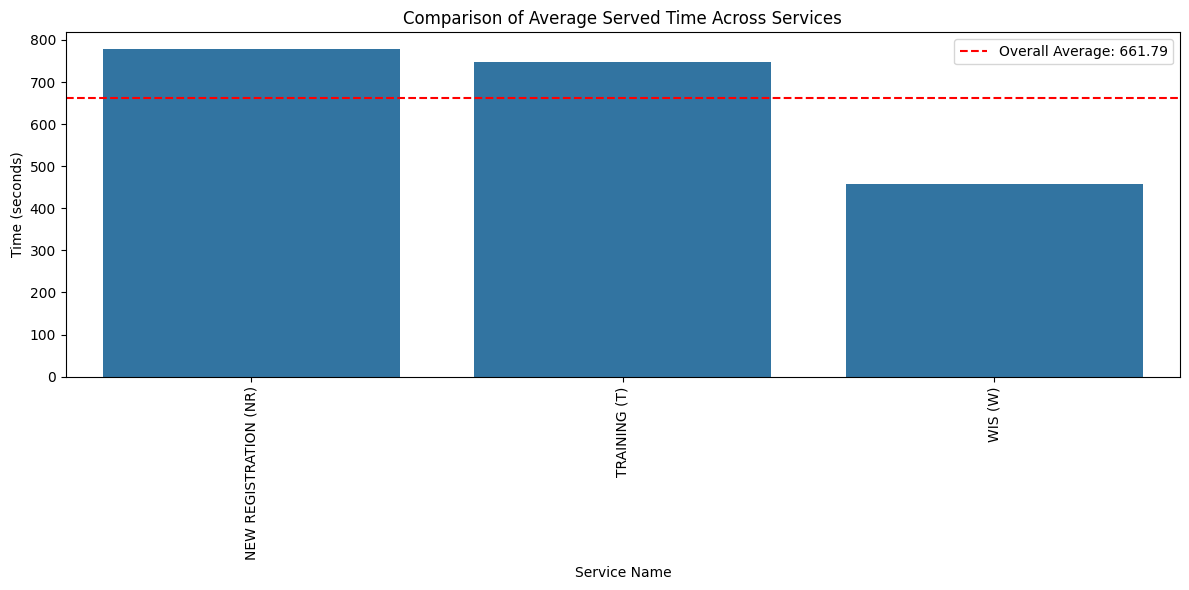

In [131]:
daily_service_wise_summary = data.groupby(['called_date', 'service_name']).agg({
    'call_id': 'count',
    'waiting_time_seconds': 'mean',
    'served_time_seconds': 'mean'
}).rename(columns={'call_id': 'number_of_calls'})

plot_comparison_overall_avg(daily_service_wise_summary, 'number_of_calls', 'Number of Calls', 'Comparison of Number of Calls Across Services', 'Average Calls', service=True)
plot_comparison_overall_avg(daily_service_wise_summary, 'waiting_time_seconds', 'Time (seconds)', 'Comparison of Average Waiting Time Across Services', 'Average Waiting Time', service=True)
plot_comparison_overall_avg(daily_service_wise_summary, 'served_time_seconds', 'Time (seconds)', 'Comparison of Average Served Time Across Services', 'Average Served Time', service=True)


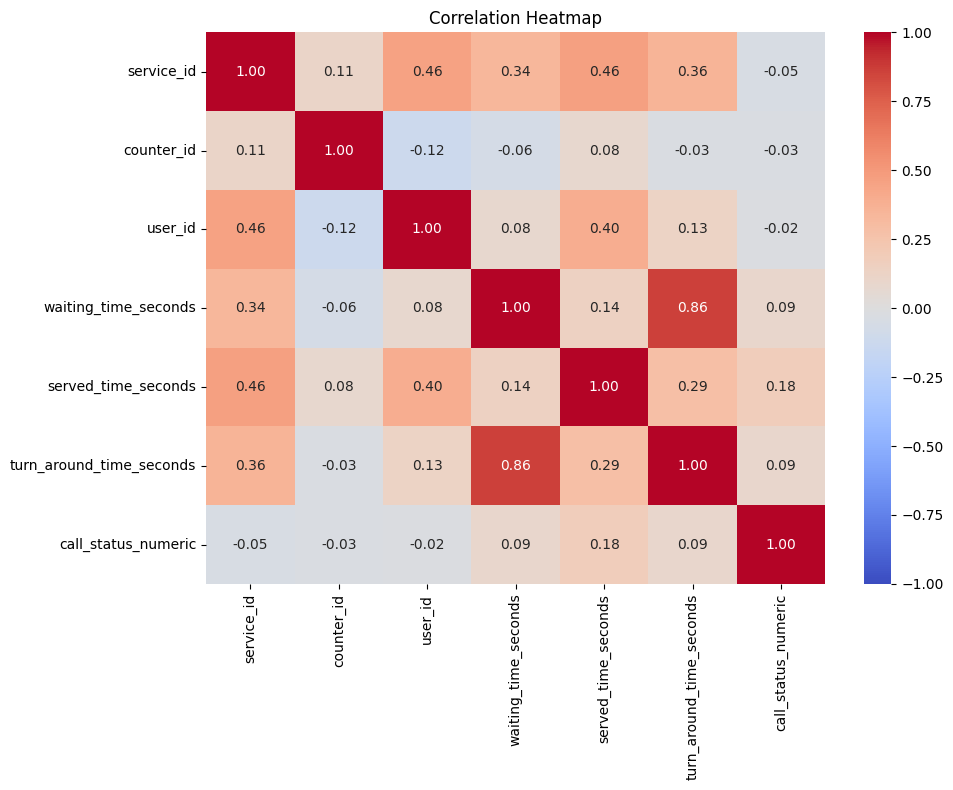

In [133]:
columns_to_use = ['service_id', 'counter_id', 'user_id', 'waiting_time_seconds', 'served_time_seconds', 'turn_around_time_seconds', 'call_status_numeric']
corr_data = data[columns_to_use]

corr_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


<ipython-input-134-31b42f1172a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='number_of_calls', data=hourly_summary, palette='viridis')


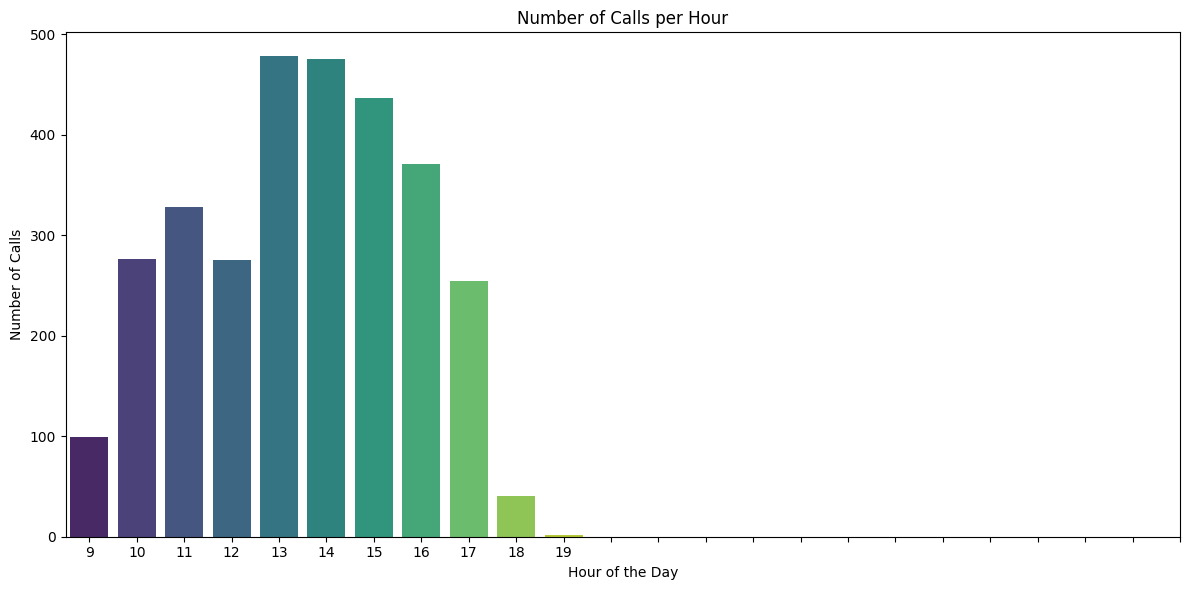

In [134]:
data['hour'] = data['started_at'].dt.hour
hourly_summary = data.groupby('hour').size().reset_index(name='number_of_calls')
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='number_of_calls', data=hourly_summary, palette='viridis')
plt.title('Number of Calls per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
plt.xticks(range(24))
plt.tight_layout()
plt.show()


In [136]:
data['hour'].unique()

array([18, 19, 10, 11, 12, 13, 14, 15, 16,  9, 17], dtype=int32)

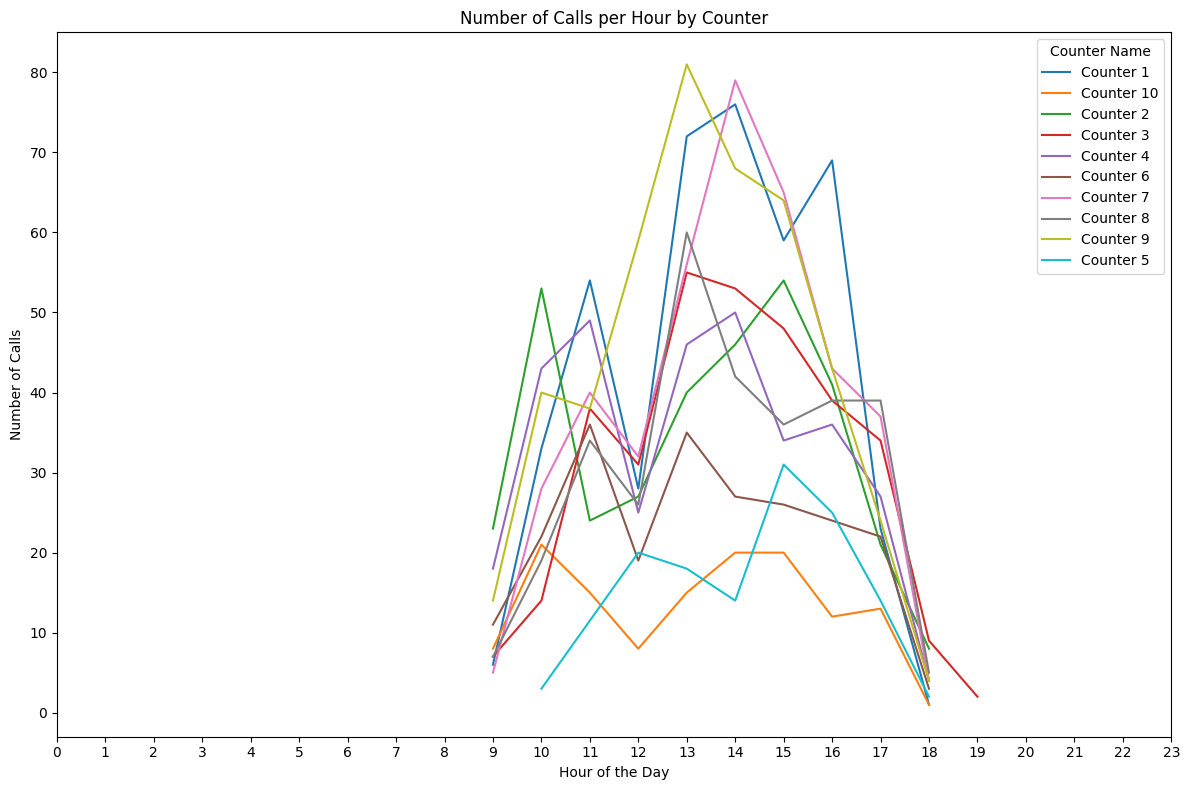

In [137]:
hourly_counter_summary = data.groupby(['hour', 'counter_name']).size().reset_index(name='number_of_calls')

plt.figure(figsize=(12, 8))
sns.lineplot(x='hour', y='number_of_calls', hue='counter_name', data=hourly_counter_summary, palette='tab10')
plt.title('Number of Calls per Hour by Counter')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
plt.xticks(range(24))  # Show all hours
plt.legend(title='Counter Name')
plt.tight_layout()
plt.show()


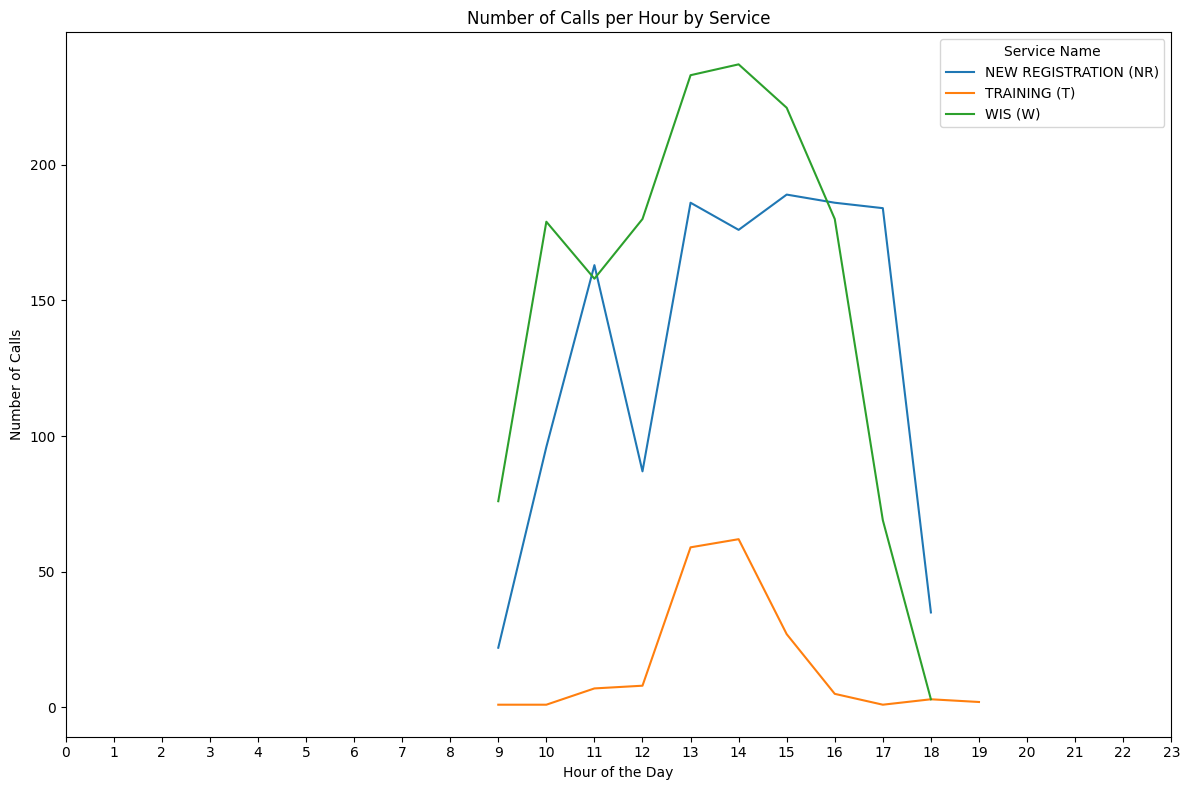

In [138]:
hourly_service_summary = data.groupby(['hour', 'service_name']).size().reset_index(name='number_of_calls')

plt.figure(figsize=(12, 8))
sns.lineplot(x='hour', y='number_of_calls', hue='service_name', data=hourly_service_summary, palette='tab10')
plt.title('Number of Calls per Hour by Service')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
plt.xticks(range(24))  # Show all hours
plt.legend(title='Service Name')
plt.tight_layout()
plt.show()


In [145]:
calls_13_to_16 = hourly_service_summary[(hourly_service_summary['hour'] >= 13) & (hourly_service_summary['hour'] <= 15)]

total_calls_13_to_16 = calls_13_to_16['number_of_calls'].sum()

print(f'Total number of calls made from 13:00 to 16:00: {total_calls_13_to_16}')


Total number of calls made from 13:00 to 16:00: 1390


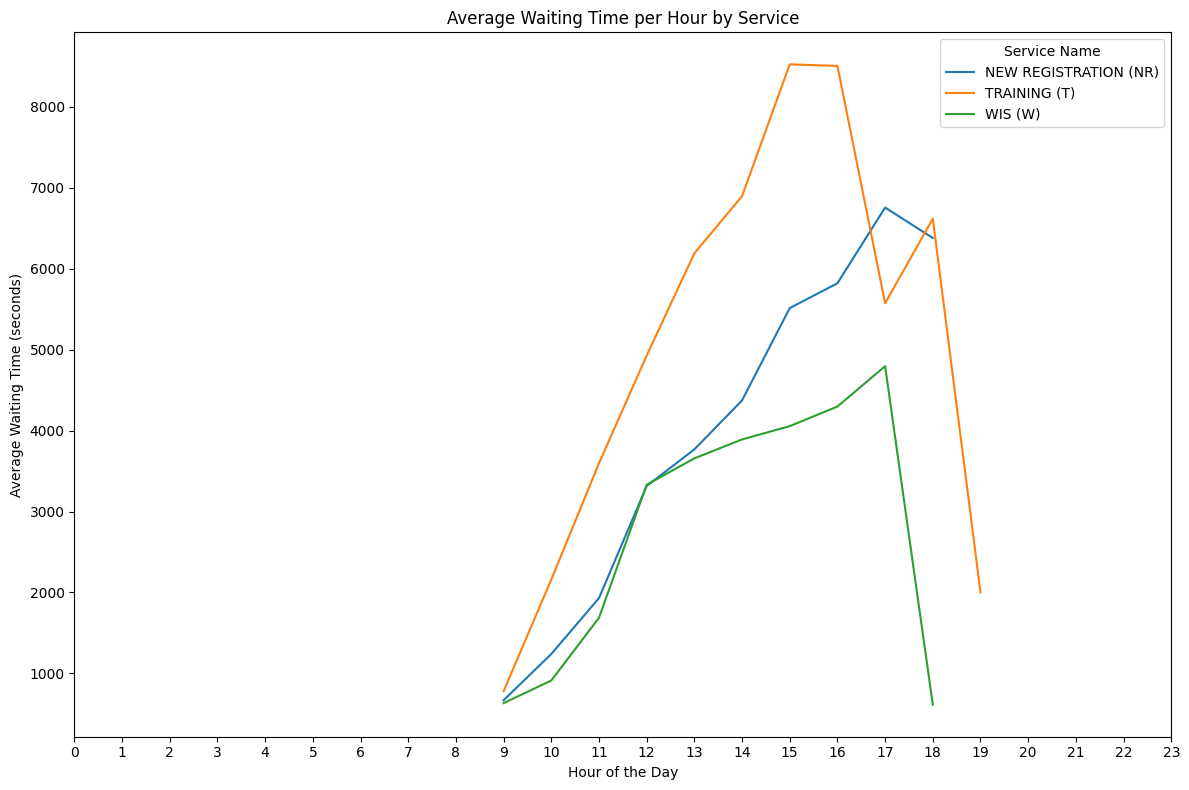

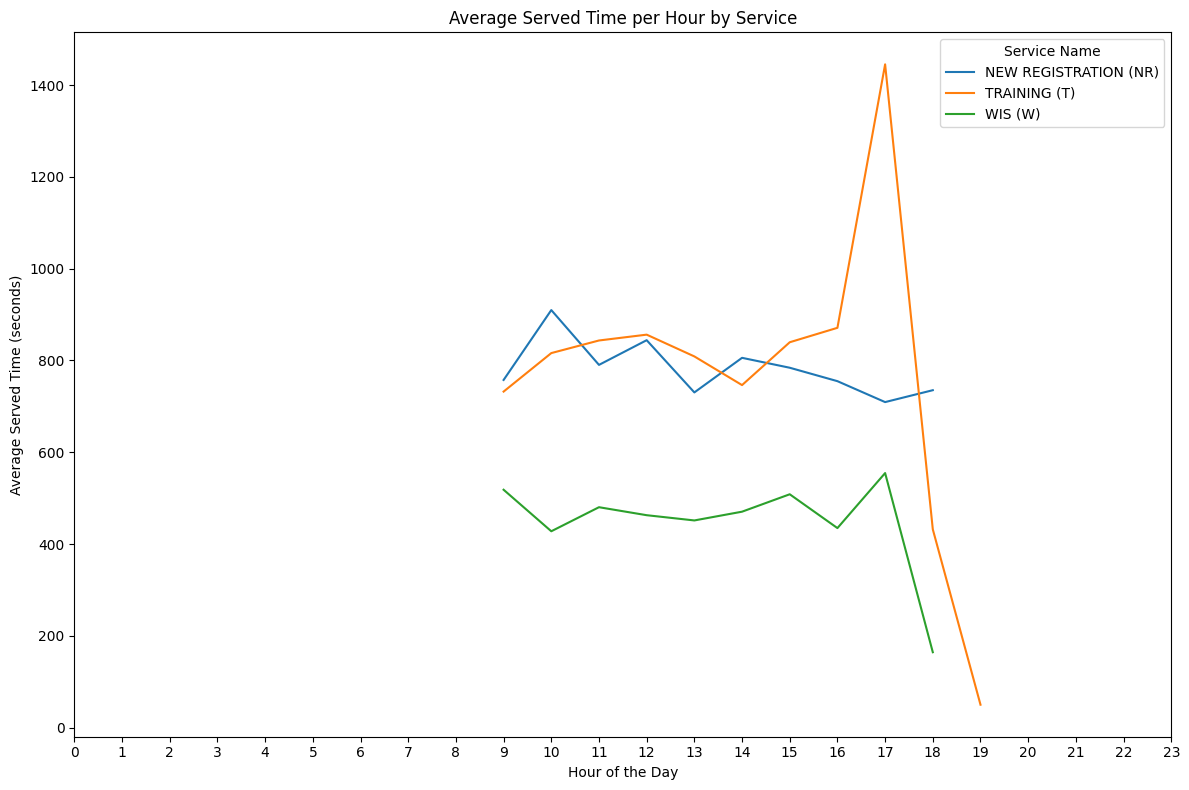

In [146]:
hourly_waiting_summary = data.groupby(['hour', 'service_name'])['waiting_time_seconds'].mean().reset_index()
hourly_served_summary = data.groupby(['hour', 'service_name'])['served_time_seconds'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(x='hour', y='waiting_time_seconds', hue='service_name', data=hourly_waiting_summary, palette='tab10')
plt.title('Average Waiting Time per Hour by Service')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Waiting Time (seconds)')
plt.xticks(range(24))  # Show all hours
plt.legend(title='Service Name')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(x='hour', y='served_time_seconds', hue='service_name', data=hourly_served_summary, palette='tab10')
plt.title('Average Served Time per Hour by Service')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Served Time (seconds)')
plt.xticks(range(24))  # Show all hours
plt.legend(title='Service Name')
plt.tight_layout()
plt.show()


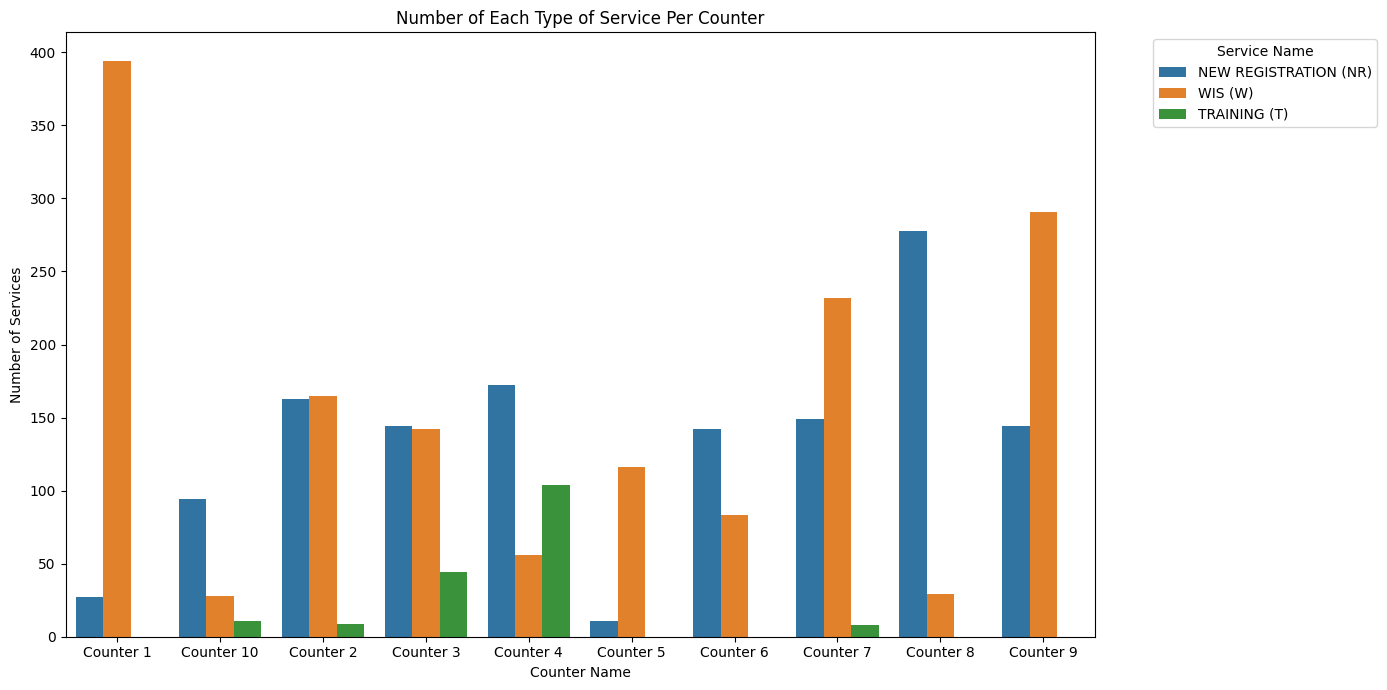

In [142]:
def plot_service_count_by_counter(data):
    service_count = data.groupby(['counter_name', 'service_name']).size().reset_index(name='count')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=service_count, x='counter_name', y='count', hue='service_name')
    plt.title('Number of Each Type of Service Per Counter')
    plt.xlabel('Counter Name')
    plt.ylabel('Number of Services')
    plt.legend(title='Service Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_service_count_by_counter(data)


**Insights:**
- Calls are unevenly distributed among counters.
- 20% of calls are no shows.
- January 25 and February 2 have very low call volumes.
- On average, 151 calls are made each day.
- Average waiting time is 62.4 minutes; lower on days with fewer calls.
- Longer wait times for training services due to limited counters (mainly 3 and 4) handling these calls.
- W services have shorter waiting and served periods.
- Counters 9 and 1 handle more calls, while counters 10 and 5 underperform.
- 45% of calls are made between 1 pm and 3 pm.

**Recommendations:**
- Balance calls and services across all counters.
- Provide T services at all counters to reduce wait times.
- Add more staff during peak hours to handle higher call volume.
- Investigate and enhance the performance of counters 10 and 5.